In [1]:
%matplotlib inline

# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import importlib
from libs import plots, params, models, feats
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)
importlib.reload(feats)

<module 'libs.feats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/feats.py'>

In [2]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
matplotlib.use("Agg")  # safe, headless-friendly
import matplotlib.pyplot as plt
plt.ioff()

import json
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path

import torch
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast

import optuna
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned
from optuna.importance import get_param_importances

from tqdm.auto import tqdm


In [3]:
if params.feat_sel == 'auto': # automatic feature selection, based on feature importance notebook
    
    df_feat_sel = pd.read_csv(params.feat_sel_auto_csv, index_col=0, parse_dates=True)
    
elif params.feat_sel == 'man': # alternative manual feature selection, based on the features selected in the params.py
    
    df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['bid','ask'] + [params.label_col]]
    
df_feat_sel

,atr_ratio,atr_ratio_sma,vol_15,bb_width_20,r_15,rsi,stoch_k_14,eng_ma,bid,ask,signal
2004-01-02 13:07:00,-0.996380,-0.987015,-1.005076,-0.943230,-0.009476,-2.476841,-1.552562,-0.001209,0.763698,0.764840,0.069210
2004-01-02 13:08:00,-0.994579,-0.986828,-1.001603,-0.937271,-0.017401,-2.476841,-1.552562,-0.001209,0.763681,0.764824,0.073291
2004-01-02 13:09:00,-0.992906,-0.986557,-0.999187,-0.930276,-0.025327,-2.476841,-1.552562,-0.001209,0.763664,0.764807,0.077619
2004-01-02 13:10:00,-0.991353,-0.986209,-0.997370,-0.922523,-0.033253,-2.476841,-1.552562,-0.001209,0.763647,0.764790,0.082208
2004-01-02 13:11:00,-0.989911,-0.985789,-0.995973,-0.914218,-0.041178,-2.476841,-1.552562,-0.001209,0.763631,0.764773,0.087074
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.582507,0.182057,0.348747,0.119570,1.315228,0.811095,0.354296,12.115664,196.667400,196.962600,0.417935
2025-06-18 20:57:00,0.641713,0.207647,0.391507,0.184714,1.113128,0.539711,0.426843,12.401440,196.527500,196.822500,0.368513
2025-06-18 20:58:00,0.574130,0.230765,0.392142,0.238300,0.827243,0.530165,0.381683,12.401440,196.522500,196.817500,0.365417
2025-06-18 20:59:00,0.695123,0.261866,0.692251,0.242399,-0.093724,-0.151391,-0.182061,9.257911,196.092800,196.387200,0.280949


In [4]:
# calculate look_backs under half the interval between the day’s first and sess_start

first_time = (
    df_feat_sel.index
        .to_series()
        .groupby(df_feat_sel.index.normalize())
        .min()
        .dt.time
        .mode()[0]
)

# convert both times to minutes since midnight
fm = first_time.hour * 60 + first_time.minute
sm = params.sess_start.hour * 60 + params.sess_start.minute

# half the difference, count full 30-min slots, and build multiples
n_steps    = int(((sm - fm) / 2) // 30)      # e.g. floor(165/30) = 5
look_backs = [30 * i for i in range(1, n_steps + 1)]
look_backs


[30, 60, 90, 120]

In [5]:
# ──────────────────────────────────────────────────────────────────────────────
# Optuna objective definition
# ──────────────────────────────────────────────────────────────────────────────

look_backs = [30, 45, 60, 75, 90]

def objective(trial):
    
    hp = {
    # ── Architecture ────────────────────────────────────────────────
    "look_back"    : trial.suggest_categorical("look_back", look_backs),
    "DROPOUT_SHORT": trial.suggest_float("DROPOUT_SHORT", 0.15, 0.35),
    "DROPOUT_LONG":  trial.suggest_float("DROPOUT_LONG",  0.2, 0.4),
    "ATT_DROPOUT":   trial.suggest_float("ATT_DROPOUT",   0.1, 0.3),
    
    # ── Optimizer & Scheduler ──────────────────────────────────────
    "INITIAL_LR":    trial.suggest_float("INITIAL_LR",    5e-5, 5e-4,   log=True),
    "ETA_MIN":       trial.suggest_float("ETA_MIN",       1e-6, 1e-5,   log=True),
    "WEIGHT_DECAY":  trial.suggest_float("WEIGHT_DECAY",  5e-4, 5e-3,  log=True),
    "CLIPNORM":      trial.suggest_float("CLIPNORM",      0.5, 1.5),
    }

    print(f"\n▶ Trial {trial.number} starting with:\n{hp}\n")

    sess_start_pred = dt.time(*divmod((params.sess_start.hour * 60 + params.sess_start.minute) - hp["look_back"], 60))
    
    print('Build LSTM input tensors (disk-backed memmaps)...')
    X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models.build_lstm_tensors(
        df            = df_feat_sel,
        sess_start    = sess_start_pred 
    )
    
    print('Split into train/val/test by calendar day...')
    (
    (X_tr,  y_sig_tr,  y_ret_tr),
    (X_val, y_sig_val, y_ret_val),
    (X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
    samples_per_day,
    day_id_tr, day_id_val, day_id_te
    ) = models.chronological_split(
        X, y_sig, y_ret,
        raw_close, raw_bid, raw_ask,
        end_times   = end_times,
        train_prop  = params.train_prop,
        val_prop    = params.val_prop,
        train_batch = params.hparams['TRAIN_BATCH']
    )

    print('Carve `end_times` into the same three splits...')
    n_tr  = day_id_tr .shape[0] 
    n_val = day_id_val.shape[0]
    i_tr  = n_tr
    i_val = n_tr + n_val
    
    end_times_tr  = end_times[:i_tr]
    end_times_val = end_times[i_tr:i_val]
    end_times_te  = end_times[i_val:]
    
    print('Build DataLoaders over calendar‐days...')
    train_loader, val_loader, test_loader = models.split_to_day_datasets(
        # train split:   
        X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
        # val split:
        X_val,           y_sig_val,    y_ret_val,  end_times_val,
        # test split + raw‐prices
        X_te,            y_sig_te,     y_ret_te,   end_times_te,
        raw_close_te, raw_bid_te, raw_ask_te,
        
        sess_start_time       = sess_start_pred,
        signal_thresh         = params.best_optuna_params["buy_threshold"],
        return_thresh         = 0.01,  # flat‐zone threshold for returns (to tune)
        train_batch           = params.hparams["TRAIN_BATCH"],
        train_workers         = params.hparams["NUM_WORKERS"],
        train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
    )

    print('Instantiate the stateful DualMemoryLSTM...')
    model = models.DualMemoryLSTM(
        n_feats        = X.shape[-1],                          
        short_units    = params.hparams['SHORT_UNITS'],    
        long_units     = params.hparams['LONG_UNITS'],     
        dropout_short  = hp["DROPOUT_SHORT"],  
        dropout_long   = hp["DROPOUT_LONG"],   
        att_heads      = params.hparams['ATT_HEADS'],
        att_drop       = hp['ATT_DROPOUT']
    )
    model.to(params.device)  

    print('Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...')
    optimizer, plateau_sched, _ , scaler, clipnorm = \
        models.make_optimizer_and_scheduler(
            model            = model,
            initial_lr       = hp["INITIAL_LR"],
            weight_decay     = hp["WEIGHT_DECAY"],
            clipnorm         = hp["CLIPNORM"]
        )
    cosine_sched = CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=params.hparams['T_0'], 
        T_mult=params.hparams['T_MULT'], 
        eta_min=hp['ETA_MIN']
    )
    
    print('Run the custom stateful training loop...')
    best_val_rmse  = models.custom_stateful_training_loop(
        model               = model,
        optimizer           = optimizer,
        cosine_sched        = cosine_sched,
        plateau_sched       = plateau_sched,
        scaler              = scaler,
        train_loader        = train_loader,
        val_loader          = val_loader,
        max_epochs          = params.hparams['MAX_EPOCHS'],
        early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
        clipnorm            = hp["CLIPNORM"],
        device              = params.device
    )

    print('Delete variables to free memory...')
    del model, optimizer, plateau_sched, cosine_sched, scaler
    del X, y_sig, y_ret, raw_close, raw_bid, raw_ask
    del X_tr,  y_sig_tr,  y_ret_tr, X_val, y_sig_val, y_ret_val, X_te,  y_sig_te,  y_ret_te
    del raw_close_te, raw_bid_te, raw_ask_te
    del train_loader, val_loader, test_loader

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return best_val_rmse


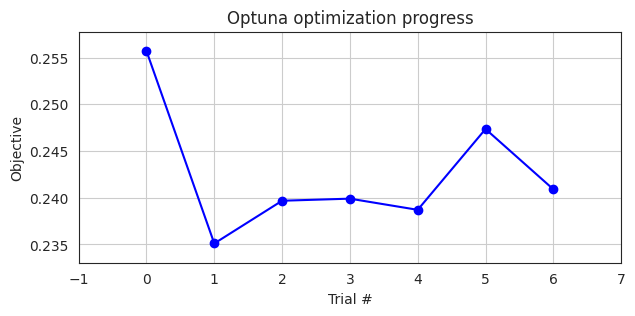

In [6]:
# build blank figure & line
fig, ax = plt.subplots(figsize=(7,3))
line, = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna optimization progress")
ax.grid(True)

# display once and grab the handle
handle = display(fig, display_id=True)
plt.close(fig)

# ask plots.py for a callback bound to these objects
live_cb = plots.make_live_plot_callback(fig, ax, line, handle)

[I 2025-09-05 21:05:00,178] A new study created in RDB with name: no-name-93dd9e10-54d7-439e-ba35-371506e99f3f



▶ Trial 0 starting with:
{'look_back': 30, 'DROPOUT_SHORT': 0.24475615362140163, 'DROPOUT_LONG': 0.3322741900658637, 'ATT_DROPOUT': 0.22417762934170532, 'INITIAL_LR': 0.0004192606845206169, 'ETA_MIN': 8.975394320399371e-06, 'WEIGHT_DECAY': 0.0005166854645469655, 'CLIPNORM': 1.1096556039391299}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_lstm_tensors, using: ['atr_ratio', 'atr_ratio_sma', 'vol_15', 'bb_width_20', 'r_15', 'rsi', 'stoch_k_14', 'eng_ma']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


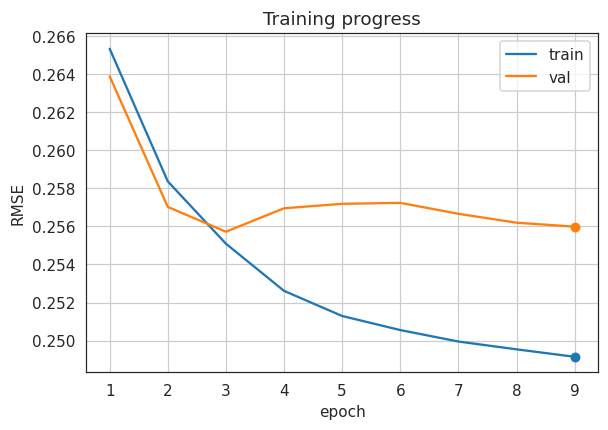

Epoch 1:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2653 MAE=0.2068 R2=0.1557 | "B": Acc=0.7385 Prec=0.4525 Rec=0.1646 F1=0.2414 AUROC=0.6054
VALID→ "R": RMSE=0.2639 MAE=0.2034 R2=0.0989 | "B": Acc=0.7410 Prec=0.4654 Rec=0.4162 F1=0.4395 AUROC=0.7087


Epoch 2:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2584 MAE=0.2022 R2=0.1994 | "B": Acc=0.7198 Prec=0.4312 Rec=0.3402 F1=0.3803 AUROC=0.6447
VALID→ "R": RMSE=0.2570 MAE=0.1952 R2=0.1451 | "B": Acc=0.7137 Prec=0.4361 Rec=0.5933 F1=0.5027 AUROC=0.7252


Epoch 3:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2551 MAE=0.1996 R2=0.2195 | "B": Acc=0.7067 Prec=0.4246 Rec=0.4510 F1=0.4374 AUROC=0.6704
VALID→ "R": RMSE=0.2557 MAE=0.1936 R2=0.1538 | "B": Acc=0.6857 Prec=0.4114 Rec=0.6696 F1=0.5096 AUROC=0.7313


Epoch 4:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2526 MAE=0.1975 R2=0.2346 | "B": Acc=0.6951 Prec=0.4167 Rec=0.5161 F1=0.4611 AUROC=0.6821
VALID→ "R": RMSE=0.2569 MAE=0.1956 R2=0.1456 | "B": Acc=0.6592 Prec=0.3918 Rec=0.7197 F1=0.5074 AUROC=0.7344


Epoch 5:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2513 MAE=0.1964 R2=0.2426 | "B": Acc=0.6860 Prec=0.4101 Rec=0.5526 F1=0.4708 AUROC=0.6879
VALID→ "R": RMSE=0.2572 MAE=0.1951 R2=0.1440 | "B": Acc=0.6531 Prec=0.3879 Rec=0.7307 F1=0.5067 AUROC=0.7335


Epoch 6:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2506 MAE=0.1956 R2=0.2470 | "B": Acc=0.6807 Prec=0.4067 Rec=0.5738 F1=0.4760 AUROC=0.6913
VALID→ "R": RMSE=0.2572 MAE=0.1950 R2=0.1437 | "B": Acc=0.6464 Prec=0.3837 Rec=0.7414 F1=0.5057 AUROC=0.7304


Epoch 7:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2500 MAE=0.1950 R2=0.2506 | "B": Acc=0.6803 Prec=0.4077 Rec=0.5848 F1=0.4805 AUROC=0.6948
VALID→ "R": RMSE=0.2567 MAE=0.1945 R2=0.1475 | "B": Acc=0.6491 Prec=0.3855 Rec=0.7393 F1=0.5068 AUROC=0.7281


Epoch 8:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2495 MAE=0.1947 R2=0.2531 | "B": Acc=0.6819 Prec=0.4093 Rec=0.5832 F1=0.4810 AUROC=0.6958
VALID→ "R": RMSE=0.2562 MAE=0.1941 R2=0.1506 | "B": Acc=0.6521 Prec=0.3875 Rec=0.7343 F1=0.5073 AUROC=0.7225


Epoch 9:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2492 MAE=0.1943 R2=0.2554 | "B": Acc=0.6826 Prec=0.4101 Rec=0.5835 F1=0.4817 AUROC=0.6968
VALID→ "R": RMSE=0.2560 MAE=0.1937 R2=0.1520 | "B": Acc=0.6543 Prec=0.3882 Rec=0.7248 F1=0.5056 AUROC=0.7183
Early stopping at epoch 9
Delete variables to free memory...


[I 2025-09-05 21:11:06,794] Trial 0 finished with value: 0.25571829080581665 and parameters: {'look_back': 30, 'DROPOUT_SHORT': 0.24475615362140163, 'DROPOUT_LONG': 0.3322741900658637, 'ATT_DROPOUT': 0.22417762934170532, 'INITIAL_LR': 0.0004192606845206169, 'ETA_MIN': 8.975394320399371e-06, 'WEIGHT_DECAY': 0.0005166854645469655, 'CLIPNORM': 1.1096556039391299}. Best is trial 0 with value: 0.25571829080581665.



▶ Trial 1 starting with:
{'look_back': 90, 'DROPOUT_SHORT': 0.24224852192320823, 'DROPOUT_LONG': 0.20026556395427586, 'ATT_DROPOUT': 0.11626816449508288, 'INITIAL_LR': 0.00019357410749158105, 'ETA_MIN': 1.6400047510067902e-06, 'WEIGHT_DECAY': 0.0012568609146224616, 'CLIPNORM': 0.7115894748106018}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_lstm_tensors, using: ['atr_ratio', 'atr_ratio_sma', 'vol_15', 'bb_width_20', 'r_15', 'rsi', 'stoch_k_14', 'eng_ma']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


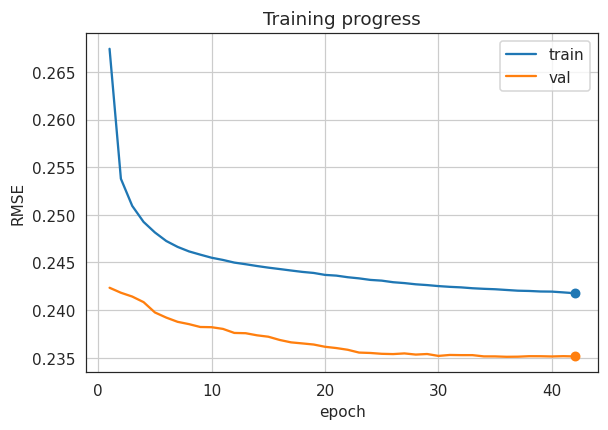

Epoch 1:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2674 MAE=0.2089 R2=0.1196 | "B": Acc=0.2936 Prec=0.2183 Rec=0.7429 F1=0.3375 AUROC=0.4071
VALID→ "R": RMSE=0.2423 MAE=0.1827 R2=0.2149 | "B": Acc=0.2243 Prec=0.2072 Rec=0.8381 F1=0.3322 AUROC=0.3141


Epoch 2:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2538 MAE=0.1976 R2=0.2071 | "B": Acc=0.2961 Prec=0.2077 Rec=0.6772 F1=0.3179 AUROC=0.3834
VALID→ "R": RMSE=0.2418 MAE=0.1844 R2=0.2182 | "B": Acc=0.2439 Prec=0.1773 Rec=0.6273 F1=0.2764 AUROC=0.2923


Epoch 3:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2509 MAE=0.1951 R2=0.2248 | "B": Acc=0.3329 Prec=0.1942 Rec=0.5572 F1=0.2881 AUROC=0.3709
VALID→ "R": RMSE=0.2414 MAE=0.1851 R2=0.2208 | "B": Acc=0.3024 Prec=0.1568 Rec=0.4636 F1=0.2343 AUROC=0.2954


Epoch 4:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2493 MAE=0.1935 R2=0.2352 | "B": Acc=0.3543 Prec=0.1878 Rec=0.5010 F1=0.2732 AUROC=0.3669
VALID→ "R": RMSE=0.2408 MAE=0.1853 R2=0.2246 | "B": Acc=0.3506 Prec=0.1466 Rec=0.3775 F1=0.2112 AUROC=0.3042


Epoch 5:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2481 MAE=0.1924 R2=0.2420 | "B": Acc=0.3676 Prec=0.1813 Rec=0.4584 F1=0.2599 AUROC=0.3608
VALID→ "R": RMSE=0.2398 MAE=0.1849 R2=0.2316 | "B": Acc=0.4103 Prec=0.1360 Rec=0.2917 F1=0.1855 AUROC=0.3146


Epoch 6:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2473 MAE=0.1915 R2=0.2474 | "B": Acc=0.3800 Prec=0.1756 Rec=0.4220 F1=0.2479 AUROC=0.3562
VALID→ "R": RMSE=0.2392 MAE=0.1845 R2=0.2350 | "B": Acc=0.4385 Prec=0.1308 Rec=0.2550 F1=0.1729 AUROC=0.3216


Epoch 7:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2466 MAE=0.1910 R2=0.2512 | "B": Acc=0.3872 Prec=0.1715 Rec=0.3993 F1=0.2399 AUROC=0.3520
VALID→ "R": RMSE=0.2388 MAE=0.1842 R2=0.2379 | "B": Acc=0.4566 Prec=0.1264 Rec=0.2300 F1=0.1631 AUROC=0.3240


Epoch 8:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2462 MAE=0.1904 R2=0.2540 | "B": Acc=0.4006 Prec=0.1683 Rec=0.3742 F1=0.2322 AUROC=0.3519
VALID→ "R": RMSE=0.2385 MAE=0.1839 R2=0.2394 | "B": Acc=0.4758 Prec=0.1243 Rec=0.2111 F1=0.1564 AUROC=0.3285


Epoch 9:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2458 MAE=0.1901 R2=0.2561 | "B": Acc=0.3986 Prec=0.1666 Rec=0.3705 F1=0.2298 AUROC=0.3489
VALID→ "R": RMSE=0.2382 MAE=0.1835 R2=0.2413 | "B": Acc=0.4799 Prec=0.1257 Rec=0.2115 F1=0.1577 AUROC=0.3335


Epoch 10:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2455 MAE=0.1898 R2=0.2581 | "B": Acc=0.4003 Prec=0.1659 Rec=0.3666 F1=0.2285 AUROC=0.3484
VALID→ "R": RMSE=0.2382 MAE=0.1836 R2=0.2415 | "B": Acc=0.4771 Prec=0.1280 Rec=0.2186 F1=0.1614 AUROC=0.3367


Epoch 11:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2453 MAE=0.1896 R2=0.2595 | "B": Acc=0.4087 Prec=0.1651 Rec=0.3554 F1=0.2255 AUROC=0.3505
VALID→ "R": RMSE=0.2380 MAE=0.1833 R2=0.2426 | "B": Acc=0.4931 Prec=0.1287 Rec=0.2082 F1=0.1591 AUROC=0.3422


Epoch 12:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2450 MAE=0.1894 R2=0.2612 | "B": Acc=0.4119 Prec=0.1643 Rec=0.3493 F1=0.2234 AUROC=0.3505
VALID→ "R": RMSE=0.2376 MAE=0.1828 R2=0.2453 | "B": Acc=0.5012 Prec=0.1287 Rec=0.2021 F1=0.1572 AUROC=0.3456


Epoch 13:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2448 MAE=0.1893 R2=0.2622 | "B": Acc=0.4195 Prec=0.1644 Rec=0.3422 F1=0.2221 AUROC=0.3537
VALID→ "R": RMSE=0.2376 MAE=0.1827 R2=0.2455 | "B": Acc=0.4981 Prec=0.1319 Rec=0.2113 F1=0.1624 AUROC=0.3496


Epoch 14:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2446 MAE=0.1890 R2=0.2633 | "B": Acc=0.4198 Prec=0.1638 Rec=0.3401 F1=0.2211 AUROC=0.3525
VALID→ "R": RMSE=0.2374 MAE=0.1826 R2=0.2469 | "B": Acc=0.5137 Prec=0.1305 Rec=0.1964 F1=0.1568 AUROC=0.3518


Epoch 15:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2445 MAE=0.1889 R2=0.2643 | "B": Acc=0.4262 Prec=0.1641 Rec=0.3344 F1=0.2201 AUROC=0.3554
VALID→ "R": RMSE=0.2372 MAE=0.1824 R2=0.2478 | "B": Acc=0.5155 Prec=0.1307 Rec=0.1954 F1=0.1566 AUROC=0.3539


Epoch 16:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2443 MAE=0.1888 R2=0.2652 | "B": Acc=0.4246 Prec=0.1627 Rec=0.3318 F1=0.2183 AUROC=0.3534
VALID→ "R": RMSE=0.2369 MAE=0.1821 R2=0.2500 | "B": Acc=0.5083 Prec=0.1302 Rec=0.1998 F1=0.1576 AUROC=0.3529


Epoch 17:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2442 MAE=0.1887 R2=0.2662 | "B": Acc=0.4260 Prec=0.1635 Rec=0.3326 F1=0.2192 AUROC=0.3543
VALID→ "R": RMSE=0.2366 MAE=0.1816 R2=0.2516 | "B": Acc=0.5167 Prec=0.1321 Rec=0.1973 F1=0.1583 AUROC=0.3577


Epoch 18:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2440 MAE=0.1885 R2=0.2670 | "B": Acc=0.4258 Prec=0.1629 Rec=0.3312 F1=0.2184 AUROC=0.3539
VALID→ "R": RMSE=0.2365 MAE=0.1816 R2=0.2523 | "B": Acc=0.5076 Prec=0.1308 Rec=0.2016 F1=0.1586 AUROC=0.3548


Epoch 19:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2439 MAE=0.1884 R2=0.2677 | "B": Acc=0.4218 Prec=0.1615 Rec=0.3310 F1=0.2171 AUROC=0.3505
VALID→ "R": RMSE=0.2364 MAE=0.1815 R2=0.2530 | "B": Acc=0.5064 Prec=0.1315 Rec=0.2042 F1=0.1600 AUROC=0.3553


Epoch 20:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2437 MAE=0.1883 R2=0.2689 | "B": Acc=0.4232 Prec=0.1612 Rec=0.3285 F1=0.2162 AUROC=0.3505
VALID→ "R": RMSE=0.2362 MAE=0.1812 R2=0.2545 | "B": Acc=0.5059 Prec=0.1314 Rec=0.2043 F1=0.1599 AUROC=0.3550


Epoch 21:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2436 MAE=0.1882 R2=0.2694 | "B": Acc=0.4252 Prec=0.1612 Rec=0.3265 F1=0.2158 AUROC=0.3516
VALID→ "R": RMSE=0.2360 MAE=0.1811 R2=0.2553 | "B": Acc=0.5081 Prec=0.1295 Rec=0.1986 F1=0.1568 AUROC=0.3529


Epoch 22:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2435 MAE=0.1881 R2=0.2704 | "B": Acc=0.4277 Prec=0.1573 Rec=0.3129 F1=0.2094 AUROC=0.3473
VALID→ "R": RMSE=0.2358 MAE=0.1808 R2=0.2565 | "B": Acc=0.5048 Prec=0.1290 Rec=0.2001 F1=0.1569 AUROC=0.3513


Epoch 23:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2433 MAE=0.1880 R2=0.2711 | "B": Acc=0.4250 Prec=0.1585 Rec=0.3189 F1=0.2117 AUROC=0.3477
VALID→ "R": RMSE=0.2355 MAE=0.1806 R2=0.2583 | "B": Acc=0.4991 Prec=0.1282 Rec=0.2026 F1=0.1570 AUROC=0.3513


Epoch 24:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2432 MAE=0.1879 R2=0.2721 | "B": Acc=0.4257 Prec=0.1596 Rec=0.3213 F1=0.2132 AUROC=0.3488
VALID→ "R": RMSE=0.2355 MAE=0.1806 R2=0.2586 | "B": Acc=0.4858 Prec=0.1295 Rec=0.2155 F1=0.1617 AUROC=0.3488


Epoch 25:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2431 MAE=0.1878 R2=0.2725 | "B": Acc=0.4265 Prec=0.1598 Rec=0.3212 F1=0.2134 AUROC=0.3497
VALID→ "R": RMSE=0.2354 MAE=0.1806 R2=0.2591 | "B": Acc=0.4890 Prec=0.1294 Rec=0.2128 F1=0.1609 AUROC=0.3499


Epoch 26:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2429 MAE=0.1877 R2=0.2735 | "B": Acc=0.4338 Prec=0.1592 Rec=0.3125 F1=0.2110 AUROC=0.3512
VALID→ "R": RMSE=0.2354 MAE=0.1805 R2=0.2593 | "B": Acc=0.4921 Prec=0.1309 Rec=0.2139 F1=0.1624 AUROC=0.3528


Epoch 27:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2428 MAE=0.1876 R2=0.2741 | "B": Acc=0.4355 Prec=0.1587 Rec=0.3094 F1=0.2098 AUROC=0.3515
VALID→ "R": RMSE=0.2355 MAE=0.1805 R2=0.2589 | "B": Acc=0.4940 Prec=0.1309 Rec=0.2125 F1=0.1620 AUROC=0.3519


Epoch 28:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2427 MAE=0.1875 R2=0.2748 | "B": Acc=0.4346 Prec=0.1598 Rec=0.3134 F1=0.2116 AUROC=0.3523
VALID→ "R": RMSE=0.2353 MAE=0.1805 R2=0.2597 | "B": Acc=0.4904 Prec=0.1302 Rec=0.2136 F1=0.1618 AUROC=0.3511


Epoch 29:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2426 MAE=0.1874 R2=0.2753 | "B": Acc=0.4376 Prec=0.1606 Rec=0.3128 F1=0.2122 AUROC=0.3545
VALID→ "R": RMSE=0.2354 MAE=0.1804 R2=0.2593 | "B": Acc=0.4881 Prec=0.1330 Rec=0.2215 F1=0.1662 AUROC=0.3542


Epoch 30:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2425 MAE=0.1873 R2=0.2760 | "B": Acc=0.4387 Prec=0.1611 Rec=0.3130 F1=0.2127 AUROC=0.3554
VALID→ "R": RMSE=0.2352 MAE=0.1803 R2=0.2605 | "B": Acc=0.4905 Prec=0.1324 Rec=0.2183 F1=0.1648 AUROC=0.3528


Epoch 31:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2424 MAE=0.1873 R2=0.2764 | "B": Acc=0.4396 Prec=0.1609 Rec=0.3115 F1=0.2122 AUROC=0.3552
VALID→ "R": RMSE=0.2353 MAE=0.1804 R2=0.2599 | "B": Acc=0.4952 Prec=0.1332 Rec=0.2166 F1=0.1650 AUROC=0.3540


Epoch 32:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2424 MAE=0.1872 R2=0.2768 | "B": Acc=0.4397 Prec=0.1596 Rec=0.3079 F1=0.2102 AUROC=0.3536
VALID→ "R": RMSE=0.2353 MAE=0.1802 R2=0.2600 | "B": Acc=0.4807 Prec=0.1326 Rec=0.2266 F1=0.1673 AUROC=0.3494


Epoch 33:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2423 MAE=0.1871 R2=0.2773 | "B": Acc=0.4400 Prec=0.1591 Rec=0.3062 F1=0.2094 AUROC=0.3530
VALID→ "R": RMSE=0.2353 MAE=0.1802 R2=0.2600 | "B": Acc=0.4951 Prec=0.1310 Rec=0.2116 F1=0.1618 AUROC=0.3496


Epoch 34:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2422 MAE=0.1871 R2=0.2777 | "B": Acc=0.4389 Prec=0.1603 Rec=0.3105 F1=0.2114 AUROC=0.3539
VALID→ "R": RMSE=0.2351 MAE=0.1801 R2=0.2608 | "B": Acc=0.4842 Prec=0.1330 Rec=0.2247 F1=0.1671 AUROC=0.3497


Epoch 35:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2422 MAE=0.1871 R2=0.2779 | "B": Acc=0.4431 Prec=0.1606 Rec=0.3073 F1=0.2110 AUROC=0.3559
VALID→ "R": RMSE=0.2351 MAE=0.1801 R2=0.2609 | "B": Acc=0.4882 Prec=0.1323 Rec=0.2200 F1=0.1652 AUROC=0.3499


Epoch 36:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2421 MAE=0.1870 R2=0.2784 | "B": Acc=0.4396 Prec=0.1608 Rec=0.3115 F1=0.2121 AUROC=0.3547
VALID→ "R": RMSE=0.2351 MAE=0.1800 R2=0.2611 | "B": Acc=0.4809 Prec=0.1329 Rec=0.2271 F1=0.1677 AUROC=0.3491


Epoch 37:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2420 MAE=0.1869 R2=0.2788 | "B": Acc=0.4390 Prec=0.1621 Rec=0.3156 F1=0.2142 AUROC=0.3560
VALID→ "R": RMSE=0.2351 MAE=0.1800 R2=0.2610 | "B": Acc=0.4777 Prec=0.1329 Rec=0.2297 F1=0.1684 AUROC=0.3478


Epoch 38:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2420 MAE=0.1869 R2=0.2790 | "B": Acc=0.4408 Prec=0.1611 Rec=0.3110 F1=0.2122 AUROC=0.3554
VALID→ "R": RMSE=0.2352 MAE=0.1801 R2=0.2607 | "B": Acc=0.4813 Prec=0.1321 Rec=0.2249 F1=0.1664 AUROC=0.3473


Epoch 39:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ "R": RMSE=0.2420 MAE=0.1868 R2=0.2793 | "B": Acc=0.4427 Prec=0.1608 Rec=0.3084 F1=0.2114 AUROC=0.3553
VALID→ "R": RMSE=0.2352 MAE=0.1801 R2=0.2607 | "B": Acc=0.4728 Prec=0.1333 Rec=0.2343 F1=0.1699 AUROC=0.3465


Epoch 40:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ "R": RMSE=0.2419 MAE=0.1868 R2=0.2794 | "B": Acc=0.4385 Prec=0.1623 Rec=0.3169 F1=0.2147 AUROC=0.3557
VALID→ "R": RMSE=0.2351 MAE=0.1799 R2=0.2609 | "B": Acc=0.4737 Prec=0.1346 Rec=0.2367 F1=0.1716 AUROC=0.3473


Epoch 41:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ "R": RMSE=0.2419 MAE=0.1868 R2=0.2799 | "B": Acc=0.4401 Prec=0.1620 Rec=0.3143 F1=0.2138 AUROC=0.3557
VALID→ "R": RMSE=0.2352 MAE=0.1799 R2=0.2607 | "B": Acc=0.4755 Prec=0.1330 Rec=0.2315 F1=0.1689 AUROC=0.3454


Epoch 42:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ "R": RMSE=0.2418 MAE=0.1867 R2=0.2804 | "B": Acc=0.4416 Prec=0.1610 Rec=0.3100 F1=0.2119 AUROC=0.3544
VALID→ "R": RMSE=0.2351 MAE=0.1799 R2=0.2609 | "B": Acc=0.4837 Prec=0.1322 Rec=0.2232 F1=0.1660 AUROC=0.3461
Early stopping at epoch 42
Delete variables to free memory...


[I 2025-09-05 21:39:18,985] Trial 1 finished with value: 0.2350999414920807 and parameters: {'look_back': 90, 'DROPOUT_SHORT': 0.24224852192320823, 'DROPOUT_LONG': 0.20026556395427586, 'ATT_DROPOUT': 0.11626816449508288, 'INITIAL_LR': 0.00019357410749158105, 'ETA_MIN': 1.6400047510067902e-06, 'WEIGHT_DECAY': 0.0012568609146224616, 'CLIPNORM': 0.7115894748106018}. Best is trial 1 with value: 0.2350999414920807.



▶ Trial 2 starting with:
{'look_back': 60, 'DROPOUT_SHORT': 0.20849892381984567, 'DROPOUT_LONG': 0.3452460336089734, 'ATT_DROPOUT': 0.20666142953255784, 'INITIAL_LR': 6.684110950626543e-05, 'ETA_MIN': 7.3913045504870385e-06, 'WEIGHT_DECAY': 0.002826699614544554, 'CLIPNORM': 0.9453061003639196}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_lstm_tensors, using: ['atr_ratio', 'atr_ratio_sma', 'vol_15', 'bb_width_20', 'r_15', 'rsi', 'stoch_k_14', 'eng_ma']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


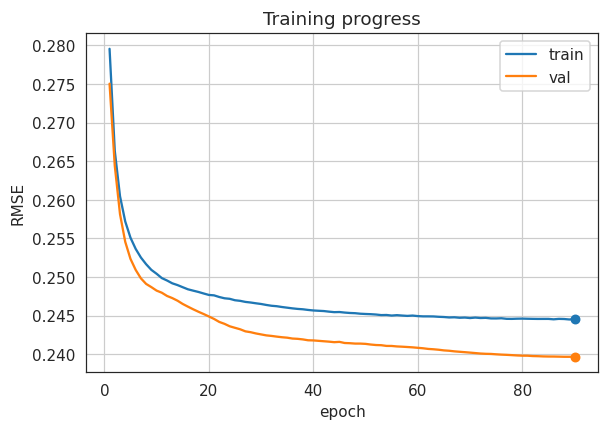

Epoch 1:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2795 MAE=0.2193 R2=0.0471 | "B": Acc=0.2721 Prec=0.2348 Rec=0.8636 F1=0.3692 AUROC=0.4385
VALID→ "R": RMSE=0.2750 MAE=0.2016 R2=0.0035 | "B": Acc=0.2319 Prec=0.2233 Rec=0.9033 F1=0.3580 AUROC=0.4088


Epoch 2:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2663 MAE=0.2054 R2=0.1351 | "B": Acc=0.2769 Prec=0.2323 Rec=0.8379 F1=0.3637 AUROC=0.4338
VALID→ "R": RMSE=0.2644 MAE=0.1956 R2=0.0791 | "B": Acc=0.2356 Prec=0.2355 Rec=0.9903 F1=0.3806 AUROC=0.4203


Epoch 3:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2605 MAE=0.2018 R2=0.1727 | "B": Acc=0.2831 Prec=0.2323 Rec=0.8276 F1=0.3628 AUROC=0.4295
VALID→ "R": RMSE=0.2581 MAE=0.1922 R2=0.1221 | "B": Acc=0.2368 Prec=0.2368 Rec=0.9984 F1=0.3828 AUROC=0.4226


Epoch 4:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2572 MAE=0.1994 R2=0.1934 | "B": Acc=0.2842 Prec=0.2316 Rec=0.8207 F1=0.3613 AUROC=0.4229
VALID→ "R": RMSE=0.2546 MAE=0.1903 R2=0.1463 | "B": Acc=0.2370 Prec=0.2369 Rec=0.9991 F1=0.3831 AUROC=0.4180


Epoch 5:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2551 MAE=0.1978 R2=0.2065 | "B": Acc=0.2824 Prec=0.2312 Rec=0.8209 F1=0.3607 AUROC=0.4179
VALID→ "R": RMSE=0.2524 MAE=0.1890 R2=0.1610 | "B": Acc=0.2369 Prec=0.2369 Rec=0.9989 F1=0.3830 AUROC=0.4124


Epoch 6:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2536 MAE=0.1968 R2=0.2155 | "B": Acc=0.2801 Prec=0.2308 Rec=0.8223 F1=0.3604 AUROC=0.4144
VALID→ "R": RMSE=0.2509 MAE=0.1879 R2=0.1705 | "B": Acc=0.2368 Prec=0.2368 Rec=0.9984 F1=0.3828 AUROC=0.4059


Epoch 7:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2525 MAE=0.1960 R2=0.2224 | "B": Acc=0.2763 Prec=0.2304 Rec=0.8266 F1=0.3604 AUROC=0.4102
VALID→ "R": RMSE=0.2498 MAE=0.1870 R2=0.1778 | "B": Acc=0.2366 Prec=0.2367 Rec=0.9975 F1=0.3826 AUROC=0.4009


Epoch 8:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2517 MAE=0.1953 R2=0.2277 | "B": Acc=0.2732 Prec=0.2302 Rec=0.8305 F1=0.3605 AUROC=0.4080
VALID→ "R": RMSE=0.2491 MAE=0.1862 R2=0.1825 | "B": Acc=0.2365 Prec=0.2365 Rec=0.9965 F1=0.3823 AUROC=0.3959


Epoch 9:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2509 MAE=0.1947 R2=0.2322 | "B": Acc=0.2716 Prec=0.2297 Rec=0.8296 F1=0.3597 AUROC=0.4055
VALID→ "R": RMSE=0.2487 MAE=0.1858 R2=0.1852 | "B": Acc=0.2360 Prec=0.2361 Rec=0.9940 F1=0.3816 AUROC=0.3914


Epoch 10:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2504 MAE=0.1943 R2=0.2353 | "B": Acc=0.2694 Prec=0.2289 Rec=0.8287 F1=0.3588 AUROC=0.4020
VALID→ "R": RMSE=0.2482 MAE=0.1853 R2=0.1882 | "B": Acc=0.2356 Prec=0.2357 Rec=0.9917 F1=0.3809 AUROC=0.3892


Epoch 11:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2499 MAE=0.1938 R2=0.2387 | "B": Acc=0.2677 Prec=0.2284 Rec=0.8282 F1=0.3581 AUROC=0.3994
VALID→ "R": RMSE=0.2480 MAE=0.1849 R2=0.1899 | "B": Acc=0.2352 Prec=0.2354 Rec=0.9897 F1=0.3803 AUROC=0.3882


Epoch 12:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2496 MAE=0.1935 R2=0.2406 | "B": Acc=0.2663 Prec=0.2275 Rec=0.8244 F1=0.3566 AUROC=0.3966
VALID→ "R": RMSE=0.2476 MAE=0.1844 R2=0.1927 | "B": Acc=0.2348 Prec=0.2350 Rec=0.9878 F1=0.3797 AUROC=0.3863


Epoch 13:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2492 MAE=0.1932 R2=0.2428 | "B": Acc=0.2661 Prec=0.2268 Rec=0.8197 F1=0.3553 AUROC=0.3936
VALID→ "R": RMSE=0.2473 MAE=0.1841 R2=0.1945 | "B": Acc=0.2344 Prec=0.2346 Rec=0.9853 F1=0.3790 AUROC=0.3837


Epoch 14:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2490 MAE=0.1930 R2=0.2442 | "B": Acc=0.2648 Prec=0.2259 Rec=0.8161 F1=0.3538 AUROC=0.3915
VALID→ "R": RMSE=0.2469 MAE=0.1838 R2=0.1967 | "B": Acc=0.2342 Prec=0.2345 Rec=0.9847 F1=0.3788 AUROC=0.3837


Epoch 15:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2487 MAE=0.1927 R2=0.2459 | "B": Acc=0.2637 Prec=0.2259 Rec=0.8183 F1=0.3541 AUROC=0.3916
VALID→ "R": RMSE=0.2465 MAE=0.1834 R2=0.1994 | "B": Acc=0.2340 Prec=0.2343 Rec=0.9837 F1=0.3785 AUROC=0.3834


Epoch 16:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2484 MAE=0.1925 R2=0.2475 | "B": Acc=0.2643 Prec=0.2251 Rec=0.8115 F1=0.3524 AUROC=0.3907
VALID→ "R": RMSE=0.2462 MAE=0.1831 R2=0.2017 | "B": Acc=0.2338 Prec=0.2341 Rec=0.9823 F1=0.3781 AUROC=0.3866


Epoch 17:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2482 MAE=0.1924 R2=0.2486 | "B": Acc=0.2640 Prec=0.2244 Rec=0.8076 F1=0.3512 AUROC=0.3895
VALID→ "R": RMSE=0.2458 MAE=0.1828 R2=0.2039 | "B": Acc=0.2337 Prec=0.2340 Rec=0.9816 F1=0.3779 AUROC=0.3870


Epoch 18:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2481 MAE=0.1922 R2=0.2496 | "B": Acc=0.2642 Prec=0.2237 Rec=0.8026 F1=0.3499 AUROC=0.3897
VALID→ "R": RMSE=0.2455 MAE=0.1824 R2=0.2059 | "B": Acc=0.2335 Prec=0.2338 Rec=0.9807 F1=0.3776 AUROC=0.3881


Epoch 19:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2479 MAE=0.1920 R2=0.2508 | "B": Acc=0.2633 Prec=0.2236 Rec=0.8037 F1=0.3499 AUROC=0.3889
VALID→ "R": RMSE=0.2452 MAE=0.1822 R2=0.2079 | "B": Acc=0.2334 Prec=0.2337 Rec=0.9797 F1=0.3773 AUROC=0.3882


Epoch 20:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2477 MAE=0.1919 R2=0.2519 | "B": Acc=0.2632 Prec=0.2228 Rec=0.7988 F1=0.3485 AUROC=0.3870
VALID→ "R": RMSE=0.2449 MAE=0.1819 R2=0.2099 | "B": Acc=0.2334 Prec=0.2337 Rec=0.9798 F1=0.3774 AUROC=0.3905


Epoch 21:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2476 MAE=0.1918 R2=0.2523 | "B": Acc=0.2636 Prec=0.2232 Rec=0.8003 F1=0.3490 AUROC=0.3891
VALID→ "R": RMSE=0.2446 MAE=0.1816 R2=0.2120 | "B": Acc=0.2332 Prec=0.2335 Rec=0.9789 F1=0.3771 AUROC=0.3913


Epoch 22:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2474 MAE=0.1916 R2=0.2536 | "B": Acc=0.2645 Prec=0.2220 Rec=0.7912 F1=0.3467 AUROC=0.3860
VALID→ "R": RMSE=0.2442 MAE=0.1813 R2=0.2145 | "B": Acc=0.2331 Prec=0.2334 Rec=0.9781 F1=0.3769 AUROC=0.3885


Epoch 23:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2472 MAE=0.1915 R2=0.2546 | "B": Acc=0.2638 Prec=0.2210 Rec=0.7862 F1=0.3450 AUROC=0.3837
VALID→ "R": RMSE=0.2439 MAE=0.1811 R2=0.2161 | "B": Acc=0.2329 Prec=0.2331 Rec=0.9765 F1=0.3764 AUROC=0.3819


Epoch 24:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2472 MAE=0.1913 R2=0.2550 | "B": Acc=0.2616 Prec=0.2207 Rec=0.7879 F1=0.3449 AUROC=0.3799
VALID→ "R": RMSE=0.2436 MAE=0.1808 R2=0.2181 | "B": Acc=0.2326 Prec=0.2329 Rec=0.9754 F1=0.3761 AUROC=0.3799


Epoch 25:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2470 MAE=0.1912 R2=0.2561 | "B": Acc=0.2619 Prec=0.2204 Rec=0.7853 F1=0.3442 AUROC=0.3801
VALID→ "R": RMSE=0.2434 MAE=0.1806 R2=0.2193 | "B": Acc=0.2324 Prec=0.2327 Rec=0.9742 F1=0.3757 AUROC=0.3823


Epoch 26:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2469 MAE=0.1912 R2=0.2565 | "B": Acc=0.2618 Prec=0.2196 Rec=0.7807 F1=0.3428 AUROC=0.3795
VALID→ "R": RMSE=0.2432 MAE=0.1806 R2=0.2206 | "B": Acc=0.2323 Prec=0.2326 Rec=0.9733 F1=0.3755 AUROC=0.3822


Epoch 27:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2468 MAE=0.1910 R2=0.2574 | "B": Acc=0.2609 Prec=0.2200 Rec=0.7846 F1=0.3437 AUROC=0.3791
VALID→ "R": RMSE=0.2430 MAE=0.1804 R2=0.2223 | "B": Acc=0.2322 Prec=0.2325 Rec=0.9728 F1=0.3753 AUROC=0.3809


Epoch 28:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2467 MAE=0.1910 R2=0.2578 | "B": Acc=0.2614 Prec=0.2195 Rec=0.7801 F1=0.3425 AUROC=0.3795
VALID→ "R": RMSE=0.2429 MAE=0.1803 R2=0.2230 | "B": Acc=0.2320 Prec=0.2322 Rec=0.9712 F1=0.3748 AUROC=0.3805


Epoch 29:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2466 MAE=0.1909 R2=0.2584 | "B": Acc=0.2600 Prec=0.2195 Rec=0.7827 F1=0.3429 AUROC=0.3781
VALID→ "R": RMSE=0.2427 MAE=0.1802 R2=0.2240 | "B": Acc=0.2320 Prec=0.2323 Rec=0.9718 F1=0.3750 AUROC=0.3811


Epoch 30:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2465 MAE=0.1907 R2=0.2590 | "B": Acc=0.2599 Prec=0.2204 Rec=0.7883 F1=0.3444 AUROC=0.3797
VALID→ "R": RMSE=0.2426 MAE=0.1801 R2=0.2248 | "B": Acc=0.2318 Prec=0.2321 Rec=0.9705 F1=0.3746 AUROC=0.3808


Epoch 31:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2464 MAE=0.1906 R2=0.2597 | "B": Acc=0.2598 Prec=0.2194 Rec=0.7823 F1=0.3427 AUROC=0.3793
VALID→ "R": RMSE=0.2424 MAE=0.1801 R2=0.2256 | "B": Acc=0.2314 Prec=0.2317 Rec=0.9679 F1=0.3739 AUROC=0.3773


Epoch 32:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2463 MAE=0.1906 R2=0.2604 | "B": Acc=0.2597 Prec=0.2191 Rec=0.7805 F1=0.3421 AUROC=0.3782
VALID→ "R": RMSE=0.2424 MAE=0.1799 R2=0.2261 | "B": Acc=0.2311 Prec=0.2313 Rec=0.9654 F1=0.3732 AUROC=0.3783


Epoch 33:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2462 MAE=0.1905 R2=0.2607 | "B": Acc=0.2590 Prec=0.2184 Rec=0.7773 F1=0.3410 AUROC=0.3758
VALID→ "R": RMSE=0.2423 MAE=0.1799 R2=0.2266 | "B": Acc=0.2310 Prec=0.2312 Rec=0.9646 F1=0.3730 AUROC=0.3772


Epoch 34:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2461 MAE=0.1904 R2=0.2613 | "B": Acc=0.2603 Prec=0.2180 Rec=0.7727 F1=0.3401 AUROC=0.3768
VALID→ "R": RMSE=0.2422 MAE=0.1798 R2=0.2272 | "B": Acc=0.2305 Prec=0.2305 Rec=0.9605 F1=0.3718 AUROC=0.3761


Epoch 35:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2460 MAE=0.1903 R2=0.2619 | "B": Acc=0.2597 Prec=0.2169 Rec=0.7665 F1=0.3381 AUROC=0.3738
VALID→ "R": RMSE=0.2421 MAE=0.1799 R2=0.2275 | "B": Acc=0.2303 Prec=0.2303 Rec=0.9590 F1=0.3714 AUROC=0.3740


Epoch 36:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2459 MAE=0.1903 R2=0.2624 | "B": Acc=0.2592 Prec=0.2171 Rec=0.7687 F1=0.3386 AUROC=0.3738
VALID→ "R": RMSE=0.2420 MAE=0.1798 R2=0.2282 | "B": Acc=0.2300 Prec=0.2298 Rec=0.9557 F1=0.3705 AUROC=0.3738


Epoch 37:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2459 MAE=0.1901 R2=0.2628 | "B": Acc=0.2609 Prec=0.2160 Rec=0.7594 F1=0.3363 AUROC=0.3729
VALID→ "R": RMSE=0.2420 MAE=0.1798 R2=0.2285 | "B": Acc=0.2293 Prec=0.2289 Rec=0.9500 F1=0.3689 AUROC=0.3727


Epoch 38:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2458 MAE=0.1901 R2=0.2631 | "B": Acc=0.2606 Prec=0.2150 Rec=0.7538 F1=0.3346 AUROC=0.3702
VALID→ "R": RMSE=0.2419 MAE=0.1798 R2=0.2289 | "B": Acc=0.2290 Prec=0.2286 Rec=0.9480 F1=0.3683 AUROC=0.3692


Epoch 39:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ "R": RMSE=0.2457 MAE=0.1900 R2=0.2636 | "B": Acc=0.2595 Prec=0.2155 Rec=0.7585 F1=0.3357 AUROC=0.3695
VALID→ "R": RMSE=0.2418 MAE=0.1798 R2=0.2297 | "B": Acc=0.2291 Prec=0.2288 Rec=0.9494 F1=0.3687 AUROC=0.3702


Epoch 40:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ "R": RMSE=0.2457 MAE=0.1899 R2=0.2640 | "B": Acc=0.2593 Prec=0.2152 Rec=0.7568 F1=0.3351 AUROC=0.3694
VALID→ "R": RMSE=0.2418 MAE=0.1798 R2=0.2298 | "B": Acc=0.2287 Prec=0.2280 Rec=0.9442 F1=0.3673 AUROC=0.3690


Epoch 41:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ "R": RMSE=0.2456 MAE=0.1899 R2=0.2643 | "B": Acc=0.2591 Prec=0.2150 Rec=0.7557 F1=0.3347 AUROC=0.3687
VALID→ "R": RMSE=0.2417 MAE=0.1797 R2=0.2301 | "B": Acc=0.2287 Prec=0.2279 Rec=0.9432 F1=0.3670 AUROC=0.3684


Epoch 42:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ "R": RMSE=0.2456 MAE=0.1898 R2=0.2645 | "B": Acc=0.2599 Prec=0.2149 Rec=0.7542 F1=0.3345 AUROC=0.3692
VALID→ "R": RMSE=0.2417 MAE=0.1797 R2=0.2305 | "B": Acc=0.2283 Prec=0.2272 Rec=0.9390 F1=0.3659 AUROC=0.3667


Epoch 43:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 043
TRAIN→ "R": RMSE=0.2455 MAE=0.1897 R2=0.2649 | "B": Acc=0.2593 Prec=0.2141 Rec=0.7501 F1=0.3331 AUROC=0.3662
VALID→ "R": RMSE=0.2416 MAE=0.1797 R2=0.2308 | "B": Acc=0.2281 Prec=0.2266 Rec=0.9347 F1=0.3648 AUROC=0.3652


Epoch 44:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 044
TRAIN→ "R": RMSE=0.2455 MAE=0.1896 R2=0.2653 | "B": Acc=0.2602 Prec=0.2137 Rec=0.7461 F1=0.3322 AUROC=0.3660
VALID→ "R": RMSE=0.2416 MAE=0.1797 R2=0.2312 | "B": Acc=0.2275 Prec=0.2255 Rec=0.9274 F1=0.3628 AUROC=0.3632


Epoch 45:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 045
TRAIN→ "R": RMSE=0.2455 MAE=0.1896 R2=0.2652 | "B": Acc=0.2593 Prec=0.2132 Rec=0.7445 F1=0.3315 AUROC=0.3642
VALID→ "R": RMSE=0.2416 MAE=0.1797 R2=0.2310 | "B": Acc=0.2273 Prec=0.2255 Rec=0.9280 F1=0.3629 AUROC=0.3626


Epoch 46:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 046
TRAIN→ "R": RMSE=0.2454 MAE=0.1895 R2=0.2657 | "B": Acc=0.2591 Prec=0.2133 Rec=0.7453 F1=0.3317 AUROC=0.3642
VALID→ "R": RMSE=0.2415 MAE=0.1796 R2=0.2319 | "B": Acc=0.2273 Prec=0.2252 Rec=0.9258 F1=0.3623 AUROC=0.3621


Epoch 47:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 047
TRAIN→ "R": RMSE=0.2453 MAE=0.1895 R2=0.2660 | "B": Acc=0.2587 Prec=0.2129 Rec=0.7434 F1=0.3309 AUROC=0.3630
VALID→ "R": RMSE=0.2414 MAE=0.1796 R2=0.2321 | "B": Acc=0.2272 Prec=0.2247 Rec=0.9220 F1=0.3613 AUROC=0.3619


Epoch 48:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 048
TRAIN→ "R": RMSE=0.2453 MAE=0.1894 R2=0.2661 | "B": Acc=0.2593 Prec=0.2125 Rec=0.7402 F1=0.3302 AUROC=0.3625
VALID→ "R": RMSE=0.2414 MAE=0.1796 R2=0.2324 | "B": Acc=0.2272 Prec=0.2246 Rec=0.9211 F1=0.3611 AUROC=0.3615


Epoch 49:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 049
TRAIN→ "R": RMSE=0.2453 MAE=0.1894 R2=0.2665 | "B": Acc=0.2594 Prec=0.2125 Rec=0.7403 F1=0.3303 AUROC=0.3627
VALID→ "R": RMSE=0.2414 MAE=0.1797 R2=0.2324 | "B": Acc=0.2271 Prec=0.2246 Rec=0.9217 F1=0.3612 AUROC=0.3605


Epoch 50:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 050
TRAIN→ "R": RMSE=0.2452 MAE=0.1893 R2=0.2667 | "B": Acc=0.2587 Prec=0.2121 Rec=0.7389 F1=0.3296 AUROC=0.3618
VALID→ "R": RMSE=0.2413 MAE=0.1797 R2=0.2326 | "B": Acc=0.2270 Prec=0.2239 Rec=0.9164 F1=0.3599 AUROC=0.3587


Epoch 51:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 051
TRAIN→ "R": RMSE=0.2452 MAE=0.1893 R2=0.2669 | "B": Acc=0.2585 Prec=0.2121 Rec=0.7391 F1=0.3296 AUROC=0.3605
VALID→ "R": RMSE=0.2413 MAE=0.1797 R2=0.2332 | "B": Acc=0.2267 Prec=0.2238 Rec=0.9161 F1=0.3597 AUROC=0.3572


Epoch 52:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 052
TRAIN→ "R": RMSE=0.2451 MAE=0.1892 R2=0.2672 | "B": Acc=0.2584 Prec=0.2116 Rec=0.7360 F1=0.3287 AUROC=0.3603
VALID→ "R": RMSE=0.2412 MAE=0.1796 R2=0.2336 | "B": Acc=0.2268 Prec=0.2230 Rec=0.9105 F1=0.3583 AUROC=0.3568


Epoch 53:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 053
TRAIN→ "R": RMSE=0.2451 MAE=0.1891 R2=0.2676 | "B": Acc=0.2588 Prec=0.2106 Rec=0.7297 F1=0.3269 AUROC=0.3589
VALID→ "R": RMSE=0.2412 MAE=0.1797 R2=0.2337 | "B": Acc=0.2268 Prec=0.2227 Rec=0.9082 F1=0.3577 AUROC=0.3557


Epoch 54:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 054
TRAIN→ "R": RMSE=0.2451 MAE=0.1891 R2=0.2675 | "B": Acc=0.2591 Prec=0.2111 Rec=0.7320 F1=0.3277 AUROC=0.3598
VALID→ "R": RMSE=0.2411 MAE=0.1796 R2=0.2343 | "B": Acc=0.2267 Prec=0.2225 Rec=0.9064 F1=0.3573 AUROC=0.3539


Epoch 55:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 055
TRAIN→ "R": RMSE=0.2450 MAE=0.1891 R2=0.2680 | "B": Acc=0.2581 Prec=0.2107 Rec=0.7312 F1=0.3271 AUROC=0.3574
VALID→ "R": RMSE=0.2411 MAE=0.1796 R2=0.2343 | "B": Acc=0.2268 Prec=0.2222 Rec=0.9045 F1=0.3568 AUROC=0.3527


Epoch 56:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 056
TRAIN→ "R": RMSE=0.2451 MAE=0.1891 R2=0.2677 | "B": Acc=0.2581 Prec=0.2105 Rec=0.7299 F1=0.3268 AUROC=0.3565
VALID→ "R": RMSE=0.2410 MAE=0.1796 R2=0.2347 | "B": Acc=0.2267 Prec=0.2219 Rec=0.9021 F1=0.3562 AUROC=0.3512


Epoch 57:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 057
TRAIN→ "R": RMSE=0.2450 MAE=0.1890 R2=0.2680 | "B": Acc=0.2585 Prec=0.2103 Rec=0.7283 F1=0.3264 AUROC=0.3561
VALID→ "R": RMSE=0.2410 MAE=0.1796 R2=0.2349 | "B": Acc=0.2270 Prec=0.2213 Rec=0.8972 F1=0.3550 AUROC=0.3504


Epoch 58:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 058
TRAIN→ "R": RMSE=0.2450 MAE=0.1890 R2=0.2682 | "B": Acc=0.2582 Prec=0.2095 Rec=0.7237 F1=0.3249 AUROC=0.3550
VALID→ "R": RMSE=0.2409 MAE=0.1796 R2=0.2352 | "B": Acc=0.2269 Prec=0.2210 Rec=0.8955 F1=0.3545 AUROC=0.3500


Epoch 59:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 059
TRAIN→ "R": RMSE=0.2450 MAE=0.1890 R2=0.2680 | "B": Acc=0.2587 Prec=0.2092 Rec=0.7213 F1=0.3243 AUROC=0.3549
VALID→ "R": RMSE=0.2409 MAE=0.1795 R2=0.2355 | "B": Acc=0.2270 Prec=0.2206 Rec=0.8926 F1=0.3538 AUROC=0.3498


Epoch 60:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 060
TRAIN→ "R": RMSE=0.2449 MAE=0.1890 R2=0.2684 | "B": Acc=0.2583 Prec=0.2089 Rec=0.7199 F1=0.3238 AUROC=0.3540
VALID→ "R": RMSE=0.2408 MAE=0.1795 R2=0.2359 | "B": Acc=0.2268 Prec=0.2205 Rec=0.8918 F1=0.3536 AUROC=0.3493


Epoch 61:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 061
TRAIN→ "R": RMSE=0.2449 MAE=0.1889 R2=0.2686 | "B": Acc=0.2581 Prec=0.2088 Rec=0.7198 F1=0.3237 AUROC=0.3533
VALID→ "R": RMSE=0.2408 MAE=0.1795 R2=0.2362 | "B": Acc=0.2269 Prec=0.2206 Rec=0.8924 F1=0.3537 AUROC=0.3492


Epoch 62:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 062
TRAIN→ "R": RMSE=0.2449 MAE=0.1889 R2=0.2686 | "B": Acc=0.2587 Prec=0.2085 Rec=0.7171 F1=0.3230 AUROC=0.3528
VALID→ "R": RMSE=0.2407 MAE=0.1796 R2=0.2368 | "B": Acc=0.2269 Prec=0.2202 Rec=0.8899 F1=0.3531 AUROC=0.3484


Epoch 63:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 063
TRAIN→ "R": RMSE=0.2449 MAE=0.1889 R2=0.2687 | "B": Acc=0.2599 Prec=0.2087 Rec=0.7165 F1=0.3232 AUROC=0.3538
VALID→ "R": RMSE=0.2407 MAE=0.1796 R2=0.2371 | "B": Acc=0.2267 Prec=0.2201 Rec=0.8889 F1=0.3528 AUROC=0.3479


Epoch 64:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 064
TRAIN→ "R": RMSE=0.2449 MAE=0.1889 R2=0.2689 | "B": Acc=0.2587 Prec=0.2086 Rec=0.7176 F1=0.3232 AUROC=0.3530
VALID→ "R": RMSE=0.2406 MAE=0.1796 R2=0.2375 | "B": Acc=0.2267 Prec=0.2205 Rec=0.8920 F1=0.3536 AUROC=0.3474


Epoch 65:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 065
TRAIN→ "R": RMSE=0.2448 MAE=0.1889 R2=0.2691 | "B": Acc=0.2584 Prec=0.2087 Rec=0.7187 F1=0.3234 AUROC=0.3527
VALID→ "R": RMSE=0.2405 MAE=0.1796 R2=0.2380 | "B": Acc=0.2266 Prec=0.2206 Rec=0.8926 F1=0.3537 AUROC=0.3473


Epoch 66:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 066
TRAIN→ "R": RMSE=0.2448 MAE=0.1888 R2=0.2694 | "B": Acc=0.2580 Prec=0.2085 Rec=0.7181 F1=0.3231 AUROC=0.3527
VALID→ "R": RMSE=0.2405 MAE=0.1797 R2=0.2383 | "B": Acc=0.2266 Prec=0.2205 Rec=0.8922 F1=0.3536 AUROC=0.3468


Epoch 67:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 067
TRAIN→ "R": RMSE=0.2448 MAE=0.1889 R2=0.2693 | "B": Acc=0.2588 Prec=0.2090 Rec=0.7199 F1=0.3239 AUROC=0.3537
VALID→ "R": RMSE=0.2404 MAE=0.1797 R2=0.2388 | "B": Acc=0.2265 Prec=0.2206 Rec=0.8928 F1=0.3537 AUROC=0.3469


Epoch 68:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 068
TRAIN→ "R": RMSE=0.2447 MAE=0.1888 R2=0.2697 | "B": Acc=0.2586 Prec=0.2086 Rec=0.7177 F1=0.3232 AUROC=0.3528
VALID→ "R": RMSE=0.2403 MAE=0.1797 R2=0.2391 | "B": Acc=0.2264 Prec=0.2205 Rec=0.8926 F1=0.3537 AUROC=0.3464


Epoch 69:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 069
TRAIN→ "R": RMSE=0.2448 MAE=0.1889 R2=0.2695 | "B": Acc=0.2586 Prec=0.2086 Rec=0.7181 F1=0.3233 AUROC=0.3527
VALID→ "R": RMSE=0.2403 MAE=0.1797 R2=0.2394 | "B": Acc=0.2263 Prec=0.2204 Rec=0.8917 F1=0.3534 AUROC=0.3456


Epoch 70:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 070
TRAIN→ "R": RMSE=0.2447 MAE=0.1888 R2=0.2699 | "B": Acc=0.2587 Prec=0.2084 Rec=0.7165 F1=0.3229 AUROC=0.3526
VALID→ "R": RMSE=0.2402 MAE=0.1797 R2=0.2398 | "B": Acc=0.2262 Prec=0.2200 Rec=0.8895 F1=0.3528 AUROC=0.3451


Epoch 71:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 071
TRAIN→ "R": RMSE=0.2448 MAE=0.1889 R2=0.2695 | "B": Acc=0.2591 Prec=0.2085 Rec=0.7166 F1=0.3230 AUROC=0.3537
VALID→ "R": RMSE=0.2402 MAE=0.1798 R2=0.2402 | "B": Acc=0.2262 Prec=0.2202 Rec=0.8909 F1=0.3531 AUROC=0.3454


Epoch 72:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 072
TRAIN→ "R": RMSE=0.2447 MAE=0.1888 R2=0.2699 | "B": Acc=0.2586 Prec=0.2081 Rec=0.7150 F1=0.3224 AUROC=0.3525
VALID→ "R": RMSE=0.2401 MAE=0.1798 R2=0.2406 | "B": Acc=0.2262 Prec=0.2202 Rec=0.8907 F1=0.3531 AUROC=0.3453


Epoch 73:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 073
TRAIN→ "R": RMSE=0.2447 MAE=0.1888 R2=0.2697 | "B": Acc=0.2594 Prec=0.2086 Rec=0.7166 F1=0.3231 AUROC=0.3536
VALID→ "R": RMSE=0.2401 MAE=0.1798 R2=0.2408 | "B": Acc=0.2262 Prec=0.2203 Rec=0.8918 F1=0.3534 AUROC=0.3458


Epoch 74:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 074
TRAIN→ "R": RMSE=0.2446 MAE=0.1888 R2=0.2702 | "B": Acc=0.2590 Prec=0.2084 Rec=0.7161 F1=0.3228 AUROC=0.3535
VALID→ "R": RMSE=0.2400 MAE=0.1799 R2=0.2409 | "B": Acc=0.2262 Prec=0.2203 Rec=0.8918 F1=0.3534 AUROC=0.3452


Epoch 75:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 075
TRAIN→ "R": RMSE=0.2446 MAE=0.1888 R2=0.2702 | "B": Acc=0.2585 Prec=0.2084 Rec=0.7168 F1=0.3229 AUROC=0.3531
VALID→ "R": RMSE=0.2400 MAE=0.1799 R2=0.2412 | "B": Acc=0.2262 Prec=0.2205 Rec=0.8928 F1=0.3537 AUROC=0.3451


Epoch 76:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 076
TRAIN→ "R": RMSE=0.2447 MAE=0.1888 R2=0.2701 | "B": Acc=0.2586 Prec=0.2083 Rec=0.7161 F1=0.3227 AUROC=0.3530
VALID→ "R": RMSE=0.2400 MAE=0.1799 R2=0.2414 | "B": Acc=0.2261 Prec=0.2201 Rec=0.8904 F1=0.3530 AUROC=0.3450


Epoch 77:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 077
TRAIN→ "R": RMSE=0.2446 MAE=0.1887 R2=0.2705 | "B": Acc=0.2589 Prec=0.2081 Rec=0.7147 F1=0.3224 AUROC=0.3526
VALID→ "R": RMSE=0.2399 MAE=0.1800 R2=0.2416 | "B": Acc=0.2260 Prec=0.2201 Rec=0.8904 F1=0.3530 AUROC=0.3448


Epoch 78:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 078
TRAIN→ "R": RMSE=0.2446 MAE=0.1887 R2=0.2705 | "B": Acc=0.2587 Prec=0.2079 Rec=0.7140 F1=0.3221 AUROC=0.3523
VALID→ "R": RMSE=0.2399 MAE=0.1800 R2=0.2419 | "B": Acc=0.2259 Prec=0.2200 Rec=0.8897 F1=0.3527 AUROC=0.3445


Epoch 79:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 079
TRAIN→ "R": RMSE=0.2446 MAE=0.1888 R2=0.2704 | "B": Acc=0.2591 Prec=0.2080 Rec=0.7135 F1=0.3221 AUROC=0.3529
VALID→ "R": RMSE=0.2399 MAE=0.1800 R2=0.2421 | "B": Acc=0.2258 Prec=0.2197 Rec=0.8878 F1=0.3522 AUROC=0.3441


Epoch 80:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 080
TRAIN→ "R": RMSE=0.2446 MAE=0.1888 R2=0.2703 | "B": Acc=0.2589 Prec=0.2076 Rec=0.7119 F1=0.3215 AUROC=0.3523
VALID→ "R": RMSE=0.2398 MAE=0.1800 R2=0.2423 | "B": Acc=0.2258 Prec=0.2199 Rec=0.8891 F1=0.3526 AUROC=0.3444


Epoch 81:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 081
TRAIN→ "R": RMSE=0.2446 MAE=0.1887 R2=0.2704 | "B": Acc=0.2591 Prec=0.2080 Rec=0.7136 F1=0.3221 AUROC=0.3524
VALID→ "R": RMSE=0.2398 MAE=0.1800 R2=0.2423 | "B": Acc=0.2258 Prec=0.2200 Rec=0.8897 F1=0.3527 AUROC=0.3439


Epoch 82:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 082
TRAIN→ "R": RMSE=0.2446 MAE=0.1887 R2=0.2705 | "B": Acc=0.2596 Prec=0.2082 Rec=0.7140 F1=0.3224 AUROC=0.3539
VALID→ "R": RMSE=0.2398 MAE=0.1800 R2=0.2426 | "B": Acc=0.2259 Prec=0.2201 Rec=0.8908 F1=0.3530 AUROC=0.3442


Epoch 83:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 083
TRAIN→ "R": RMSE=0.2446 MAE=0.1887 R2=0.2706 | "B": Acc=0.2589 Prec=0.2080 Rec=0.7138 F1=0.3221 AUROC=0.3522
VALID→ "R": RMSE=0.2398 MAE=0.1800 R2=0.2427 | "B": Acc=0.2258 Prec=0.2201 Rec=0.8908 F1=0.3530 AUROC=0.3441


Epoch 84:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 084
TRAIN→ "R": RMSE=0.2446 MAE=0.1887 R2=0.2706 | "B": Acc=0.2591 Prec=0.2081 Rec=0.7141 F1=0.3222 AUROC=0.3535
VALID→ "R": RMSE=0.2397 MAE=0.1800 R2=0.2429 | "B": Acc=0.2258 Prec=0.2200 Rec=0.8899 F1=0.3528 AUROC=0.3439


Epoch 85:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 085
TRAIN→ "R": RMSE=0.2446 MAE=0.1887 R2=0.2706 | "B": Acc=0.2593 Prec=0.2080 Rec=0.7132 F1=0.3220 AUROC=0.3524
VALID→ "R": RMSE=0.2397 MAE=0.1800 R2=0.2430 | "B": Acc=0.2258 Prec=0.2202 Rec=0.8915 F1=0.3532 AUROC=0.3440


Epoch 86:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 086
TRAIN→ "R": RMSE=0.2445 MAE=0.1887 R2=0.2709 | "B": Acc=0.2588 Prec=0.2080 Rec=0.7140 F1=0.3221 AUROC=0.3526
VALID→ "R": RMSE=0.2397 MAE=0.1801 R2=0.2430 | "B": Acc=0.2258 Prec=0.2203 Rec=0.8921 F1=0.3533 AUROC=0.3442


Epoch 87:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 087
TRAIN→ "R": RMSE=0.2446 MAE=0.1887 R2=0.2705 | "B": Acc=0.2597 Prec=0.2082 Rec=0.7143 F1=0.3225 AUROC=0.3533
VALID→ "R": RMSE=0.2397 MAE=0.1800 R2=0.2431 | "B": Acc=0.2258 Prec=0.2202 Rec=0.8915 F1=0.3532 AUROC=0.3443


Epoch 88:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 088
TRAIN→ "R": RMSE=0.2446 MAE=0.1887 R2=0.2706 | "B": Acc=0.2592 Prec=0.2080 Rec=0.7136 F1=0.3221 AUROC=0.3532
VALID→ "R": RMSE=0.2397 MAE=0.1800 R2=0.2432 | "B": Acc=0.2258 Prec=0.2201 Rec=0.8910 F1=0.3530 AUROC=0.3442


Epoch 89:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 089
TRAIN→ "R": RMSE=0.2445 MAE=0.1887 R2=0.2710 | "B": Acc=0.2593 Prec=0.2080 Rec=0.7136 F1=0.3221 AUROC=0.3533
VALID→ "R": RMSE=0.2397 MAE=0.1800 R2=0.2432 | "B": Acc=0.2258 Prec=0.2201 Rec=0.8909 F1=0.3530 AUROC=0.3443


Epoch 90:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 090
TRAIN→ "R": RMSE=0.2446 MAE=0.1887 R2=0.2707 | "B": Acc=0.2596 Prec=0.2081 Rec=0.7135 F1=0.3222 AUROC=0.3537
VALID→ "R": RMSE=0.2397 MAE=0.1800 R2=0.2432 | "B": Acc=0.2258 Prec=0.2202 Rec=0.8914 F1=0.3532 AUROC=0.3446
Delete variables to free memory...


[I 2025-09-05 22:36:48,011] Trial 2 finished with value: 0.2396770417690277 and parameters: {'look_back': 60, 'DROPOUT_SHORT': 0.20849892381984567, 'DROPOUT_LONG': 0.3452460336089734, 'ATT_DROPOUT': 0.20666142953255784, 'INITIAL_LR': 6.684110950626543e-05, 'ETA_MIN': 7.3913045504870385e-06, 'WEIGHT_DECAY': 0.002826699614544554, 'CLIPNORM': 0.9453061003639196}. Best is trial 1 with value: 0.2350999414920807.



▶ Trial 3 starting with:
{'look_back': 75, 'DROPOUT_SHORT': 0.34910357510172346, 'DROPOUT_LONG': 0.24525116125842125, 'ATT_DROPOUT': 0.2501309319905125, 'INITIAL_LR': 0.00012710628175926705, 'ETA_MIN': 1.2062912316009147e-06, 'WEIGHT_DECAY': 0.0013544377240887967, 'CLIPNORM': 0.6106481259777263}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_lstm_tensors, using: ['atr_ratio', 'atr_ratio_sma', 'vol_15', 'bb_width_20', 'r_15', 'rsi', 'stoch_k_14', 'eng_ma']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


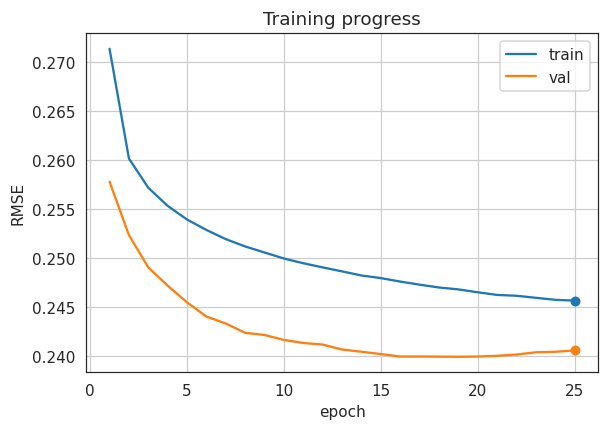

Epoch 1:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2713 MAE=0.2112 R2=0.0988 | "B": Acc=0.4563 Prec=0.2067 Rec=0.4318 F1=0.2796 AUROC=0.4298
VALID→ "R": RMSE=0.2578 MAE=0.1873 R2=0.1199 | "B": Acc=0.5696 Prec=0.1448 Rec=0.1710 F1=0.1568 AUROC=0.3565


Epoch 2:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2601 MAE=0.2017 R2=0.1717 | "B": Acc=0.5064 Prec=0.1875 Rec=0.3061 F1=0.2326 AUROC=0.4105
VALID→ "R": RMSE=0.2523 MAE=0.1848 R2=0.1567 | "B": Acc=0.6071 Prec=0.1372 Rec=0.1283 F1=0.1326 AUROC=0.3465


Epoch 3:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2571 MAE=0.1998 R2=0.1906 | "B": Acc=0.5058 Prec=0.1799 Rec=0.2874 F1=0.2213 AUROC=0.4002
VALID→ "R": RMSE=0.2490 MAE=0.1835 R2=0.1787 | "B": Acc=0.6094 Prec=0.1300 Rec=0.1175 F1=0.1234 AUROC=0.3413


Epoch 4:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2553 MAE=0.1983 R2=0.2022 | "B": Acc=0.5048 Prec=0.1785 Rec=0.2850 F1=0.2195 AUROC=0.3991
VALID→ "R": RMSE=0.2472 MAE=0.1826 R2=0.1909 | "B": Acc=0.5926 Prec=0.1261 Rec=0.1248 F1=0.1254 AUROC=0.3324


Epoch 5:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2539 MAE=0.1973 R2=0.2108 | "B": Acc=0.4968 Prec=0.1764 Rec=0.2889 F1=0.2191 AUROC=0.3937
VALID→ "R": RMSE=0.2455 MAE=0.1816 R2=0.2020 | "B": Acc=0.5655 Prec=0.1355 Rec=0.1590 F1=0.1463 AUROC=0.3326


Epoch 6:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2528 MAE=0.1964 R2=0.2174 | "B": Acc=0.4943 Prec=0.1798 Rec=0.3005 F1=0.2250 AUROC=0.3972
VALID→ "R": RMSE=0.2440 MAE=0.1807 R2=0.2114 | "B": Acc=0.5499 Prec=0.1421 Rec=0.1831 F1=0.1600 AUROC=0.3361


Epoch 7:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2519 MAE=0.1956 R2=0.2232 | "B": Acc=0.5017 Prec=0.1828 Rec=0.2996 F1=0.2271 AUROC=0.4020
VALID→ "R": RMSE=0.2433 MAE=0.1797 R2=0.2160 | "B": Acc=0.5354 Prec=0.1527 Rec=0.2164 F1=0.1790 AUROC=0.3461


Epoch 8:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2512 MAE=0.1950 R2=0.2278 | "B": Acc=0.5041 Prec=0.1889 Rec=0.3126 F1=0.2355 AUROC=0.4105
VALID→ "R": RMSE=0.2423 MAE=0.1790 R2=0.2221 | "B": Acc=0.5104 Prec=0.1630 Rec=0.2639 F1=0.2015 AUROC=0.3577


Epoch 9:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2505 MAE=0.1945 R2=0.2316 | "B": Acc=0.5190 Prec=0.1943 Rec=0.3078 F1=0.2382 AUROC=0.4203
VALID→ "R": RMSE=0.2421 MAE=0.1784 R2=0.2235 | "B": Acc=0.5169 Prec=0.1716 Rec=0.2778 F1=0.2121 AUROC=0.3705


Epoch 10:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2499 MAE=0.1940 R2=0.2354 | "B": Acc=0.5304 Prec=0.1984 Rec=0.3034 F1=0.2399 AUROC=0.4288
VALID→ "R": RMSE=0.2416 MAE=0.1780 R2=0.2267 | "B": Acc=0.5438 Prec=0.1800 Rec=0.2668 F1=0.2150 AUROC=0.3785


Epoch 11:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2494 MAE=0.1935 R2=0.2383 | "B": Acc=0.5403 Prec=0.2007 Rec=0.2956 F1=0.2391 AUROC=0.4327
VALID→ "R": RMSE=0.2413 MAE=0.1777 R2=0.2287 | "B": Acc=0.5650 Prec=0.1907 Rec=0.2645 F1=0.2216 AUROC=0.3893


Epoch 12:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2490 MAE=0.1931 R2=0.2409 | "B": Acc=0.5518 Prec=0.2033 Rec=0.2859 F1=0.2376 AUROC=0.4374
VALID→ "R": RMSE=0.2411 MAE=0.1774 R2=0.2298 | "B": Acc=0.5697 Prec=0.1936 Rec=0.2647 F1=0.2236 AUROC=0.3914


Epoch 13:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2486 MAE=0.1927 R2=0.2434 | "B": Acc=0.5527 Prec=0.2046 Rec=0.2877 F1=0.2391 AUROC=0.4396
VALID→ "R": RMSE=0.2406 MAE=0.1772 R2=0.2330 | "B": Acc=0.6059 Prec=0.2067 Rec=0.2407 F1=0.2224 AUROC=0.3964


Epoch 14:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2482 MAE=0.1923 R2=0.2459 | "B": Acc=0.5689 Prec=0.2091 Rec=0.2748 F1=0.2375 AUROC=0.4468
VALID→ "R": RMSE=0.2404 MAE=0.1770 R2=0.2344 | "B": Acc=0.6387 Prec=0.2244 Rec=0.2212 F1=0.2228 AUROC=0.4087


Epoch 15:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2479 MAE=0.1921 R2=0.2475 | "B": Acc=0.5794 Prec=0.2135 Rec=0.2689 F1=0.2380 AUROC=0.4536
VALID→ "R": RMSE=0.2402 MAE=0.1768 R2=0.2359 | "B": Acc=0.6562 Prec=0.2330 Rec=0.2045 F1=0.2178 AUROC=0.4115


Epoch 16:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2476 MAE=0.1918 R2=0.2497 | "B": Acc=0.5891 Prec=0.2145 Rec=0.2561 F1=0.2335 AUROC=0.4562
VALID→ "R": RMSE=0.2399 MAE=0.1767 R2=0.2376 | "B": Acc=0.6712 Prec=0.2429 Rec=0.1910 F1=0.2138 AUROC=0.4166


Epoch 17:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2473 MAE=0.1915 R2=0.2516 | "B": Acc=0.5944 Prec=0.2148 Rec=0.2487 F1=0.2305 AUROC=0.4574
VALID→ "R": RMSE=0.2399 MAE=0.1766 R2=0.2375 | "B": Acc=0.6879 Prec=0.2507 Rec=0.1676 F1=0.2009 AUROC=0.4179


Epoch 18:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2470 MAE=0.1912 R2=0.2533 | "B": Acc=0.6009 Prec=0.2178 Rec=0.2446 F1=0.2304 AUROC=0.4608
VALID→ "R": RMSE=0.2399 MAE=0.1764 R2=0.2376 | "B": Acc=0.7008 Prec=0.2601 Rec=0.1508 F1=0.1909 AUROC=0.4236


Epoch 19:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2468 MAE=0.1911 R2=0.2545 | "B": Acc=0.6096 Prec=0.2185 Rec=0.2320 F1=0.2250 AUROC=0.4633
VALID→ "R": RMSE=0.2399 MAE=0.1763 R2=0.2377 | "B": Acc=0.7221 Prec=0.2714 Rec=0.1110 F1=0.1576 AUROC=0.4197


Epoch 20:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2465 MAE=0.1908 R2=0.2563 | "B": Acc=0.6107 Prec=0.2164 Rec=0.2264 F1=0.2213 AUROC=0.4612
VALID→ "R": RMSE=0.2399 MAE=0.1763 R2=0.2375 | "B": Acc=0.7214 Prec=0.2674 Rec=0.1093 F1=0.1552 AUROC=0.4163


Epoch 21:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2462 MAE=0.1905 R2=0.2579 | "B": Acc=0.6103 Prec=0.2157 Rec=0.2258 F1=0.2206 AUROC=0.4589
VALID→ "R": RMSE=0.2400 MAE=0.1763 R2=0.2371 | "B": Acc=0.7243 Prec=0.2691 Rec=0.1035 F1=0.1495 AUROC=0.4210


Epoch 22:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2461 MAE=0.1905 R2=0.2584 | "B": Acc=0.6155 Prec=0.2198 Rec=0.2250 F1=0.2224 AUROC=0.4649
VALID→ "R": RMSE=0.2401 MAE=0.1763 R2=0.2363 | "B": Acc=0.7273 Prec=0.2650 Rec=0.0928 F1=0.1375 AUROC=0.4186


Epoch 23:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2459 MAE=0.1903 R2=0.2597 | "B": Acc=0.6188 Prec=0.2184 Rec=0.2173 F1=0.2178 AUROC=0.4625
VALID→ "R": RMSE=0.2404 MAE=0.1764 R2=0.2348 | "B": Acc=0.7350 Prec=0.2828 Rec=0.0860 F1=0.1319 AUROC=0.4209


Epoch 24:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2457 MAE=0.1901 R2=0.2609 | "B": Acc=0.6212 Prec=0.2180 Rec=0.2128 F1=0.2154 AUROC=0.4614
VALID→ "R": RMSE=0.2404 MAE=0.1765 R2=0.2345 | "B": Acc=0.7399 Prec=0.2942 Rec=0.0795 F1=0.1251 AUROC=0.4216


Epoch 25:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2456 MAE=0.1900 R2=0.2614 | "B": Acc=0.6247 Prec=0.2189 Rec=0.2087 F1=0.2137 AUROC=0.4643
VALID→ "R": RMSE=0.2405 MAE=0.1766 R2=0.2336 | "B": Acc=0.7434 Prec=0.3039 Rec=0.0743 F1=0.1195 AUROC=0.4228
Early stopping at epoch 25
Delete variables to free memory...


[I 2025-09-05 22:53:12,001] Trial 3 finished with value: 0.23989996314048767 and parameters: {'look_back': 75, 'DROPOUT_SHORT': 0.34910357510172346, 'DROPOUT_LONG': 0.24525116125842125, 'ATT_DROPOUT': 0.2501309319905125, 'INITIAL_LR': 0.00012710628175926705, 'ETA_MIN': 1.2062912316009147e-06, 'WEIGHT_DECAY': 0.0013544377240887967, 'CLIPNORM': 0.6106481259777263}. Best is trial 1 with value: 0.2350999414920807.



▶ Trial 4 starting with:
{'look_back': 90, 'DROPOUT_SHORT': 0.2796431670817394, 'DROPOUT_LONG': 0.2803491324094002, 'ATT_DROPOUT': 0.12741800092366334, 'INITIAL_LR': 0.0003135279676352312, 'ETA_MIN': 1.0466426709509936e-06, 'WEIGHT_DECAY': 0.0006207278095861538, 'CLIPNORM': 1.186205719058776}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_lstm_tensors, using: ['atr_ratio', 'atr_ratio_sma', 'vol_15', 'bb_width_20', 'r_15', 'rsi', 'stoch_k_14', 'eng_ma']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


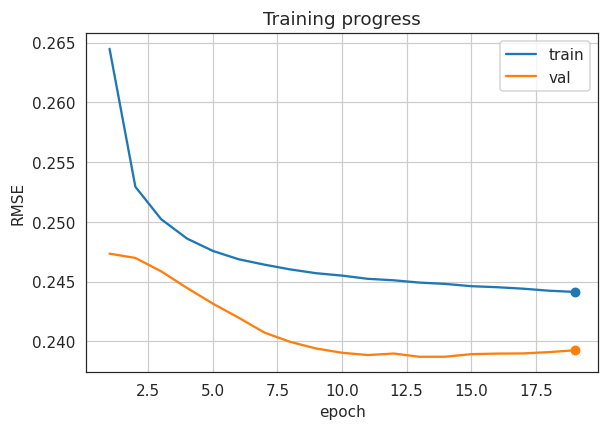

Epoch 1:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2645 MAE=0.2071 R2=0.1389 | "B": Acc=0.5768 Prec=0.2119 Rec=0.2747 F1=0.2392 AUROC=0.4540
VALID→ "R": RMSE=0.2473 MAE=0.1863 R2=0.1822 | "B": Acc=0.7707 Prec=0.6436 Rec=0.0093 F1=0.0184 AUROC=0.3915


Epoch 2:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2529 MAE=0.1964 R2=0.2125 | "B": Acc=0.6549 Prec=0.2386 Rec=0.1938 F1=0.2139 AUROC=0.4820
VALID→ "R": RMSE=0.2470 MAE=0.1867 R2=0.1846 | "B": Acc=0.7739 Prec=0.6610 Rec=0.0367 F1=0.0695 AUROC=0.4878


Epoch 3:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2502 MAE=0.1937 R2=0.2293 | "B": Acc=0.6618 Prec=0.2808 Rec=0.2538 F1=0.2666 AUROC=0.5283
VALID→ "R": RMSE=0.2459 MAE=0.1862 R2=0.1920 | "B": Acc=0.7696 Prec=0.4979 Rec=0.0966 F1=0.1619 AUROC=0.5396


Epoch 4:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2486 MAE=0.1922 R2=0.2392 | "B": Acc=0.6691 Prec=0.3140 Rec=0.3092 F1=0.3116 AUROC=0.5662
VALID→ "R": RMSE=0.2445 MAE=0.1856 R2=0.2011 | "B": Acc=0.7575 Prec=0.4330 Rec=0.1720 F1=0.2462 AUROC=0.5789


Epoch 5:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2476 MAE=0.1913 R2=0.2456 | "B": Acc=0.6688 Prec=0.3306 Rec=0.3584 F1=0.3440 AUROC=0.5893
VALID→ "R": RMSE=0.2432 MAE=0.1849 R2=0.2096 | "B": Acc=0.7530 Prec=0.4317 Rec=0.2296 F1=0.2997 AUROC=0.6136


Epoch 6:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2469 MAE=0.1908 R2=0.2498 | "B": Acc=0.6688 Prec=0.3398 Rec=0.3897 F1=0.3630 AUROC=0.6025
VALID→ "R": RMSE=0.2420 MAE=0.1844 R2=0.2173 | "B": Acc=0.7496 Prec=0.4327 Rec=0.2817 F1=0.3412 AUROC=0.6335


Epoch 7:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2464 MAE=0.1905 R2=0.2525 | "B": Acc=0.6731 Prec=0.3501 Rec=0.4082 F1=0.3769 AUROC=0.6161
VALID→ "R": RMSE=0.2407 MAE=0.1834 R2=0.2253 | "B": Acc=0.7480 Prec=0.4358 Rec=0.3214 F1=0.3700 AUROC=0.6498


Epoch 8:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2460 MAE=0.1902 R2=0.2550 | "B": Acc=0.6770 Prec=0.3568 Rec=0.4153 F1=0.3838 AUROC=0.6234
VALID→ "R": RMSE=0.2399 MAE=0.1825 R2=0.2303 | "B": Acc=0.7470 Prec=0.4359 Rec=0.3369 F1=0.3801 AUROC=0.6572


Epoch 9:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2457 MAE=0.1899 R2=0.2569 | "B": Acc=0.6847 Prec=0.3658 Rec=0.4110 F1=0.3871 AUROC=0.6302
VALID→ "R": RMSE=0.2394 MAE=0.1817 R2=0.2339 | "B": Acc=0.7434 Prec=0.4311 Rec=0.3582 F1=0.3913 AUROC=0.6598


Epoch 10:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2455 MAE=0.1897 R2=0.2581 | "B": Acc=0.6823 Prec=0.3670 Rec=0.4298 F1=0.3959 AUROC=0.6359
VALID→ "R": RMSE=0.2390 MAE=0.1812 R2=0.2361 | "B": Acc=0.7396 Prec=0.4273 Rec=0.3851 F1=0.4051 AUROC=0.6701


Epoch 11:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2452 MAE=0.1895 R2=0.2597 | "B": Acc=0.6817 Prec=0.3697 Rec=0.4456 F1=0.4041 AUROC=0.6412
VALID→ "R": RMSE=0.2388 MAE=0.1805 R2=0.2374 | "B": Acc=0.7335 Prec=0.4201 Rec=0.4132 F1=0.4166 AUROC=0.6793


Epoch 12:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2451 MAE=0.1894 R2=0.2604 | "B": Acc=0.6819 Prec=0.3703 Rec=0.4475 F1=0.4052 AUROC=0.6433
VALID→ "R": RMSE=0.2390 MAE=0.1804 R2=0.2365 | "B": Acc=0.7319 Prec=0.4164 Rec=0.4094 F1=0.4129 AUROC=0.6783


Epoch 13:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2449 MAE=0.1891 R2=0.2616 | "B": Acc=0.6800 Prec=0.3693 Rec=0.4539 F1=0.4073 AUROC=0.6439
VALID→ "R": RMSE=0.2387 MAE=0.1800 R2=0.2383 | "B": Acc=0.7317 Prec=0.4178 Rec=0.4199 F1=0.4188 AUROC=0.6844


Epoch 14:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2448 MAE=0.1890 R2=0.2623 | "B": Acc=0.6790 Prec=0.3684 Rec=0.4553 F1=0.4073 AUROC=0.6435
VALID→ "R": RMSE=0.2387 MAE=0.1798 R2=0.2383 | "B": Acc=0.7278 Prec=0.4133 Rec=0.4338 F1=0.4233 AUROC=0.6854


Epoch 15:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2446 MAE=0.1888 R2=0.2634 | "B": Acc=0.6811 Prec=0.3718 Rec=0.4594 F1=0.4110 AUROC=0.6464
VALID→ "R": RMSE=0.2389 MAE=0.1798 R2=0.2369 | "B": Acc=0.7332 Prec=0.4225 Rec=0.4334 F1=0.4279 AUROC=0.6904


Epoch 16:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2445 MAE=0.1888 R2=0.2639 | "B": Acc=0.6801 Prec=0.3715 Rec=0.4632 F1=0.4123 AUROC=0.6470
VALID→ "R": RMSE=0.2390 MAE=0.1796 R2=0.2366 | "B": Acc=0.7296 Prec=0.4188 Rec=0.4492 F1=0.4335 AUROC=0.6938


Epoch 17:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2444 MAE=0.1887 R2=0.2647 | "B": Acc=0.6782 Prec=0.3710 Rec=0.4728 F1=0.4158 AUROC=0.6485
VALID→ "R": RMSE=0.2390 MAE=0.1794 R2=0.2365 | "B": Acc=0.7281 Prec=0.4156 Rec=0.4453 F1=0.4299 AUROC=0.6917


Epoch 18:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2442 MAE=0.1885 R2=0.2657 | "B": Acc=0.6797 Prec=0.3717 Rec=0.4673 F1=0.4141 AUROC=0.6481
VALID→ "R": RMSE=0.2391 MAE=0.1794 R2=0.2358 | "B": Acc=0.7290 Prec=0.4181 Rec=0.4514 F1=0.4341 AUROC=0.6947


Epoch 19:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2441 MAE=0.1884 R2=0.2663 | "B": Acc=0.6780 Prec=0.3726 Rec=0.4819 F1=0.4203 AUROC=0.6526
VALID→ "R": RMSE=0.2392 MAE=0.1794 R2=0.2348 | "B": Acc=0.7244 Prec=0.4157 Rec=0.4860 F1=0.4481 AUROC=0.7022
Early stopping at epoch 19
Delete variables to free memory...


[I 2025-09-05 23:05:52,248] Trial 4 finished with value: 0.23870320618152618 and parameters: {'look_back': 90, 'DROPOUT_SHORT': 0.2796431670817394, 'DROPOUT_LONG': 0.2803491324094002, 'ATT_DROPOUT': 0.12741800092366334, 'INITIAL_LR': 0.0003135279676352312, 'ETA_MIN': 1.0466426709509936e-06, 'WEIGHT_DECAY': 0.0006207278095861538, 'CLIPNORM': 1.186205719058776}. Best is trial 1 with value: 0.2350999414920807.



▶ Trial 5 starting with:
{'look_back': 90, 'DROPOUT_SHORT': 0.33631382277951194, 'DROPOUT_LONG': 0.3912735092577751, 'ATT_DROPOUT': 0.1968766913895425, 'INITIAL_LR': 8.819489173987906e-05, 'ETA_MIN': 9.507769147454663e-06, 'WEIGHT_DECAY': 0.002556540237000644, 'CLIPNORM': 0.8333348247599547}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_lstm_tensors, using: ['atr_ratio', 'atr_ratio_sma', 'vol_15', 'bb_width_20', 'r_15', 'rsi', 'stoch_k_14', 'eng_ma']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


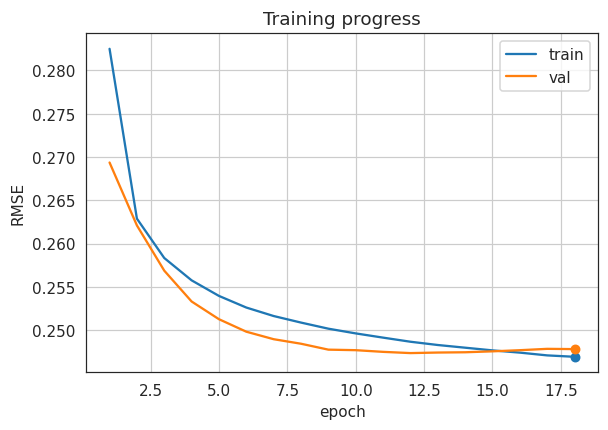

Epoch 1:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2825 MAE=0.2197 R2=0.0176 | "B": Acc=0.4804 Prec=0.2012 Rec=0.3854 F1=0.2643 AUROC=0.4255
VALID→ "R": RMSE=0.2694 MAE=0.1936 R2=0.0300 | "B": Acc=0.6534 Prec=0.2036 Rec=0.1736 F1=0.1874 AUROC=0.3814


Epoch 2:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2629 MAE=0.2025 R2=0.1493 | "B": Acc=0.4623 Prec=0.2112 Rec=0.4460 F1=0.2866 AUROC=0.4389
VALID→ "R": RMSE=0.2621 MAE=0.1888 R2=0.0817 | "B": Acc=0.5858 Prec=0.2008 Rec=0.2682 F1=0.2297 AUROC=0.4068


Epoch 3:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2583 MAE=0.1998 R2=0.1784 | "B": Acc=0.4365 Prec=0.2176 Rec=0.5111 F1=0.3052 AUROC=0.4466
VALID→ "R": RMSE=0.2569 MAE=0.1854 R2=0.1179 | "B": Acc=0.5798 Prec=0.2097 Rec=0.2980 F1=0.2461 AUROC=0.4252


Epoch 4:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2558 MAE=0.1982 R2=0.1948 | "B": Acc=0.4483 Prec=0.2177 Rec=0.4926 F1=0.3019 AUROC=0.4480
VALID→ "R": RMSE=0.2533 MAE=0.1831 R2=0.1422 | "B": Acc=0.5891 Prec=0.2116 Rec=0.2878 F1=0.2439 AUROC=0.4273


Epoch 5:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2540 MAE=0.1969 R2=0.2060 | "B": Acc=0.4542 Prec=0.2176 Rec=0.4829 F1=0.3000 AUROC=0.4491
VALID→ "R": RMSE=0.2513 MAE=0.1817 R2=0.1560 | "B": Acc=0.5839 Prec=0.2138 Rec=0.3015 F1=0.2502 AUROC=0.4298


Epoch 6:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2526 MAE=0.1958 R2=0.2144 | "B": Acc=0.4567 Prec=0.2189 Rec=0.4840 F1=0.3015 AUROC=0.4520
VALID→ "R": RMSE=0.2498 MAE=0.1807 R2=0.1656 | "B": Acc=0.5729 Prec=0.2178 Rec=0.3300 F1=0.2624 AUROC=0.4327


Epoch 7:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2516 MAE=0.1950 R2=0.2205 | "B": Acc=0.4549 Prec=0.2184 Rec=0.4849 F1=0.3011 AUROC=0.4508
VALID→ "R": RMSE=0.2490 MAE=0.1801 R2=0.1714 | "B": Acc=0.5442 Prec=0.2131 Rec=0.3636 F1=0.2687 AUROC=0.4256


Epoch 8:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2509 MAE=0.1943 R2=0.2252 | "B": Acc=0.4533 Prec=0.2183 Rec=0.4870 F1=0.3014 AUROC=0.4499
VALID→ "R": RMSE=0.2484 MAE=0.1797 R2=0.1749 | "B": Acc=0.5310 Prec=0.2146 Rec=0.3899 F1=0.2769 AUROC=0.4283


Epoch 9:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2502 MAE=0.1938 R2=0.2295 | "B": Acc=0.4472 Prec=0.2178 Rec=0.4947 F1=0.3024 AUROC=0.4482
VALID→ "R": RMSE=0.2478 MAE=0.1794 R2=0.1794 | "B": Acc=0.4807 Prec=0.2058 Rec=0.4390 F1=0.2802 AUROC=0.4215


Epoch 10:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2496 MAE=0.1933 R2=0.2329 | "B": Acc=0.4415 Prec=0.2155 Rec=0.4945 F1=0.3002 AUROC=0.4432
VALID→ "R": RMSE=0.2477 MAE=0.1793 R2=0.1798 | "B": Acc=0.4651 Prec=0.2032 Rec=0.4529 F1=0.2805 AUROC=0.4191


Epoch 11:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2491 MAE=0.1929 R2=0.2359 | "B": Acc=0.4411 Prec=0.2161 Rec=0.4978 F1=0.3014 AUROC=0.4440
VALID→ "R": RMSE=0.2475 MAE=0.1792 R2=0.1811 | "B": Acc=0.4605 Prec=0.2048 Rec=0.4659 F1=0.2845 AUROC=0.4224


Epoch 12:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2487 MAE=0.1924 R2=0.2388 | "B": Acc=0.4375 Prec=0.2153 Rec=0.4999 F1=0.3009 AUROC=0.4423
VALID→ "R": RMSE=0.2474 MAE=0.1792 R2=0.1821 | "B": Acc=0.4380 Prec=0.2037 Rec=0.4952 F1=0.2886 AUROC=0.4253


Epoch 13:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2483 MAE=0.1921 R2=0.2411 | "B": Acc=0.4321 Prec=0.2155 Rec=0.5095 F1=0.3029 AUROC=0.4418
VALID→ "R": RMSE=0.2474 MAE=0.1794 R2=0.1816 | "B": Acc=0.4270 Prec=0.2032 Rec=0.5096 F1=0.2905 AUROC=0.4271


Epoch 14:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2480 MAE=0.1918 R2=0.2430 | "B": Acc=0.4366 Prec=0.2157 Rec=0.5030 F1=0.3019 AUROC=0.4430
VALID→ "R": RMSE=0.2475 MAE=0.1795 R2=0.1814 | "B": Acc=0.4408 Prec=0.2045 Rec=0.4941 F1=0.2892 AUROC=0.4243


Epoch 15:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2477 MAE=0.1915 R2=0.2449 | "B": Acc=0.4361 Prec=0.2157 Rec=0.5037 F1=0.3020 AUROC=0.4429
VALID→ "R": RMSE=0.2476 MAE=0.1796 R2=0.1807 | "B": Acc=0.4330 Prec=0.2031 Rec=0.5002 F1=0.2889 AUROC=0.4227


Epoch 16:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2474 MAE=0.1913 R2=0.2465 | "B": Acc=0.4372 Prec=0.2151 Rec=0.4998 F1=0.3008 AUROC=0.4415
VALID→ "R": RMSE=0.2477 MAE=0.1797 R2=0.1799 | "B": Acc=0.4296 Prec=0.2041 Rec=0.5096 F1=0.2915 AUROC=0.4253


Epoch 17:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2471 MAE=0.1910 R2=0.2484 | "B": Acc=0.4336 Prec=0.2163 Rec=0.5103 F1=0.3039 AUROC=0.4435
VALID→ "R": RMSE=0.2478 MAE=0.1798 R2=0.1788 | "B": Acc=0.4194 Prec=0.2030 Rec=0.5202 F1=0.2921 AUROC=0.4250


Epoch 18:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2469 MAE=0.1908 R2=0.2494 | "B": Acc=0.4312 Prec=0.2163 Rec=0.5142 F1=0.3045 AUROC=0.4431
VALID→ "R": RMSE=0.2478 MAE=0.1799 R2=0.1790 | "B": Acc=0.4098 Prec=0.2004 Rec=0.5227 F1=0.2897 AUROC=0.4211
Early stopping at epoch 18
Delete variables to free memory...


[I 2025-09-05 23:17:50,607] Trial 5 finished with value: 0.24735772609710693 and parameters: {'look_back': 90, 'DROPOUT_SHORT': 0.33631382277951194, 'DROPOUT_LONG': 0.3912735092577751, 'ATT_DROPOUT': 0.1968766913895425, 'INITIAL_LR': 8.819489173987906e-05, 'ETA_MIN': 9.507769147454663e-06, 'WEIGHT_DECAY': 0.002556540237000644, 'CLIPNORM': 0.8333348247599547}. Best is trial 1 with value: 0.2350999414920807.



▶ Trial 6 starting with:
{'look_back': 60, 'DROPOUT_SHORT': 0.28299868075062695, 'DROPOUT_LONG': 0.32035183093972297, 'ATT_DROPOUT': 0.19764690109512656, 'INITIAL_LR': 7.582357264181803e-05, 'ETA_MIN': 2.7663412955466917e-06, 'WEIGHT_DECAY': 0.004175160708327976, 'CLIPNORM': 1.2838388011514938}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_lstm_tensors, using: ['atr_ratio', 'atr_ratio_sma', 'vol_15', 'bb_width_20', 'r_15', 'rsi', 'stoch_k_14', 'eng_ma']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


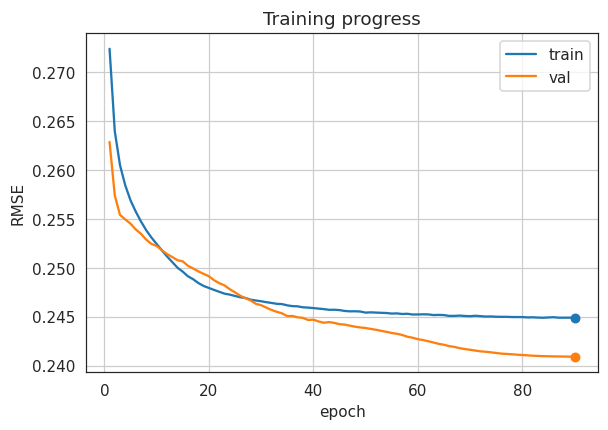

Epoch 1:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2724 MAE=0.2121 R2=0.0953 | "B": Acc=0.4091 Prec=0.2269 Rec=0.5797 F1=0.3261 AUROC=0.4537
VALID→ "R": RMSE=0.2629 MAE=0.1917 R2=0.0897 | "B": Acc=0.3364 Prec=0.2110 Rec=0.6568 F1=0.3194 AUROC=0.4672


Epoch 2:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2640 MAE=0.2051 R2=0.1504 | "B": Acc=0.4088 Prec=0.2234 Rec=0.5640 F1=0.3200 AUROC=0.4472
VALID→ "R": RMSE=0.2574 MAE=0.1904 R2=0.1272 | "B": Acc=0.3211 Prec=0.2090 Rec=0.6690 F1=0.3185 AUROC=0.4635


Epoch 3:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2605 MAE=0.2027 R2=0.1726 | "B": Acc=0.4245 Prec=0.2251 Rec=0.5457 F1=0.3187 AUROC=0.4527
VALID→ "R": RMSE=0.2554 MAE=0.1901 R2=0.1406 | "B": Acc=0.3266 Prec=0.2091 Rec=0.6611 F1=0.3177 AUROC=0.4603


Epoch 4:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2584 MAE=0.2011 R2=0.1856 | "B": Acc=0.4374 Prec=0.2235 Rec=0.5178 F1=0.3123 AUROC=0.4512
VALID→ "R": RMSE=0.2549 MAE=0.1905 R2=0.1437 | "B": Acc=0.3319 Prec=0.2089 Rec=0.6523 F1=0.3164 AUROC=0.4526


Epoch 5:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2569 MAE=0.1999 R2=0.1952 | "B": Acc=0.4347 Prec=0.2205 Rec=0.5095 F1=0.3078 AUROC=0.4447
VALID→ "R": RMSE=0.2545 MAE=0.1905 R2=0.1466 | "B": Acc=0.3258 Prec=0.2093 Rec=0.6637 F1=0.3182 AUROC=0.4440


Epoch 6:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2558 MAE=0.1990 R2=0.2024 | "B": Acc=0.4174 Prec=0.2177 Rec=0.5254 F1=0.3079 AUROC=0.4354
VALID→ "R": RMSE=0.2539 MAE=0.1904 R2=0.1506 | "B": Acc=0.3132 Prec=0.2085 Rec=0.6786 F1=0.3190 AUROC=0.4318


Epoch 7:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2547 MAE=0.1981 R2=0.2087 | "B": Acc=0.4084 Prec=0.2163 Rec=0.5329 F1=0.3077 AUROC=0.4306
VALID→ "R": RMSE=0.2535 MAE=0.1903 R2=0.1535 | "B": Acc=0.3141 Prec=0.2066 Rec=0.6667 F1=0.3155 AUROC=0.4203


Epoch 8:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2539 MAE=0.1974 R2=0.2142 | "B": Acc=0.4010 Prec=0.2135 Rec=0.5323 F1=0.3048 AUROC=0.4234
VALID→ "R": RMSE=0.2529 MAE=0.1899 R2=0.1575 | "B": Acc=0.3086 Prec=0.2050 Rec=0.6658 F1=0.3135 AUROC=0.4100


Epoch 9:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2531 MAE=0.1967 R2=0.2188 | "B": Acc=0.3933 Prec=0.2117 Rec=0.5359 F1=0.3035 AUROC=0.4173
VALID→ "R": RMSE=0.2524 MAE=0.1897 R2=0.1604 | "B": Acc=0.3028 Prec=0.2040 Rec=0.6688 F1=0.3126 AUROC=0.4020


Epoch 10:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2524 MAE=0.1962 R2=0.2229 | "B": Acc=0.3815 Prec=0.2091 Rec=0.5417 F1=0.3017 AUROC=0.4086
VALID→ "R": RMSE=0.2522 MAE=0.1895 R2=0.1619 | "B": Acc=0.2949 Prec=0.2032 Rec=0.6755 F1=0.3124 AUROC=0.3925


Epoch 11:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2518 MAE=0.1956 R2=0.2269 | "B": Acc=0.3707 Prec=0.2067 Rec=0.5468 F1=0.3000 AUROC=0.4002
VALID→ "R": RMSE=0.2518 MAE=0.1890 R2=0.1647 | "B": Acc=0.2889 Prec=0.2028 Rec=0.6821 F1=0.3126 AUROC=0.3843


Epoch 12:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2512 MAE=0.1950 R2=0.2308 | "B": Acc=0.3625 Prec=0.2053 Rec=0.5518 F1=0.2992 AUROC=0.3938
VALID→ "R": RMSE=0.2514 MAE=0.1887 R2=0.1673 | "B": Acc=0.2845 Prec=0.2020 Rec=0.6841 F1=0.3119 AUROC=0.3768


Epoch 13:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2506 MAE=0.1945 R2=0.2343 | "B": Acc=0.3509 Prec=0.2040 Rec=0.5620 F1=0.2993 AUROC=0.3865
VALID→ "R": RMSE=0.2511 MAE=0.1884 R2=0.1694 | "B": Acc=0.2783 Prec=0.2030 Rec=0.6985 F1=0.3146 AUROC=0.3700


Epoch 14:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2500 MAE=0.1940 R2=0.2378 | "B": Acc=0.3414 Prec=0.2040 Rec=0.5757 F1=0.3013 AUROC=0.3822
VALID→ "R": RMSE=0.2508 MAE=0.1881 R2=0.1715 | "B": Acc=0.2754 Prec=0.2041 Rec=0.7091 F1=0.3169 AUROC=0.3676


Epoch 15:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2496 MAE=0.1936 R2=0.2402 | "B": Acc=0.3363 Prec=0.2031 Rec=0.5783 F1=0.3006 AUROC=0.3775
VALID→ "R": RMSE=0.2507 MAE=0.1880 R2=0.1723 | "B": Acc=0.2754 Prec=0.2047 Rec=0.7125 F1=0.3180 AUROC=0.3657


Epoch 16:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2491 MAE=0.1932 R2=0.2432 | "B": Acc=0.3320 Prec=0.2029 Rec=0.5831 F1=0.3010 AUROC=0.3747
VALID→ "R": RMSE=0.2502 MAE=0.1876 R2=0.1753 | "B": Acc=0.2725 Prec=0.2065 Rec=0.7277 F1=0.3217 AUROC=0.3643


Epoch 17:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2488 MAE=0.1928 R2=0.2450 | "B": Acc=0.3264 Prec=0.2036 Rec=0.5947 F1=0.3034 AUROC=0.3722
VALID→ "R": RMSE=0.2499 MAE=0.1874 R2=0.1771 | "B": Acc=0.2726 Prec=0.2056 Rec=0.7223 F1=0.3201 AUROC=0.3596


Epoch 18:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2484 MAE=0.1925 R2=0.2473 | "B": Acc=0.3215 Prec=0.2029 Rec=0.5980 F1=0.3030 AUROC=0.3676
VALID→ "R": RMSE=0.2496 MAE=0.1871 R2=0.1790 | "B": Acc=0.2708 Prec=0.2067 Rec=0.7313 F1=0.3223 AUROC=0.3568


Epoch 19:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2481 MAE=0.1922 R2=0.2492 | "B": Acc=0.3170 Prec=0.2034 Rec=0.6066 F1=0.3046 AUROC=0.3662
VALID→ "R": RMSE=0.2494 MAE=0.1870 R2=0.1807 | "B": Acc=0.2705 Prec=0.2068 Rec=0.7326 F1=0.3226 AUROC=0.3550


Epoch 20:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2479 MAE=0.1920 R2=0.2504 | "B": Acc=0.3125 Prec=0.2037 Rec=0.6142 F1=0.3059 AUROC=0.3637
VALID→ "R": RMSE=0.2491 MAE=0.1868 R2=0.1823 | "B": Acc=0.2699 Prec=0.2075 Rec=0.7378 F1=0.3240 AUROC=0.3535


Epoch 21:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2477 MAE=0.1918 R2=0.2516 | "B": Acc=0.3098 Prec=0.2045 Rec=0.6224 F1=0.3079 AUROC=0.3627
VALID→ "R": RMSE=0.2487 MAE=0.1864 R2=0.1850 | "B": Acc=0.2675 Prec=0.2089 Rec=0.7496 F1=0.3267 AUROC=0.3528


Epoch 22:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2475 MAE=0.1916 R2=0.2528 | "B": Acc=0.3069 Prec=0.2053 Rec=0.6302 F1=0.3097 AUROC=0.3613
VALID→ "R": RMSE=0.2484 MAE=0.1862 R2=0.1870 | "B": Acc=0.2669 Prec=0.2089 Rec=0.7509 F1=0.3269 AUROC=0.3513


Epoch 23:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2474 MAE=0.1915 R2=0.2539 | "B": Acc=0.3046 Prec=0.2048 Rec=0.6311 F1=0.3093 AUROC=0.3596
VALID→ "R": RMSE=0.2482 MAE=0.1860 R2=0.1884 | "B": Acc=0.2688 Prec=0.2078 Rec=0.7413 F1=0.3247 AUROC=0.3488


Epoch 24:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2473 MAE=0.1913 R2=0.2545 | "B": Acc=0.3029 Prec=0.2042 Rec=0.6303 F1=0.3084 AUROC=0.3567
VALID→ "R": RMSE=0.2478 MAE=0.1857 R2=0.1910 | "B": Acc=0.2697 Prec=0.2078 Rec=0.7394 F1=0.3244 AUROC=0.3494


Epoch 25:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2471 MAE=0.1912 R2=0.2553 | "B": Acc=0.3023 Prec=0.2038 Rec=0.6294 F1=0.3080 AUROC=0.3557
VALID→ "R": RMSE=0.2475 MAE=0.1855 R2=0.1931 | "B": Acc=0.2694 Prec=0.2076 Rec=0.7390 F1=0.3241 AUROC=0.3473


Epoch 26:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2470 MAE=0.1910 R2=0.2561 | "B": Acc=0.3002 Prec=0.2037 Rec=0.6317 F1=0.3081 AUROC=0.3538
VALID→ "R": RMSE=0.2472 MAE=0.1853 R2=0.1953 | "B": Acc=0.2697 Prec=0.2076 Rec=0.7388 F1=0.3242 AUROC=0.3467


Epoch 27:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2469 MAE=0.1910 R2=0.2566 | "B": Acc=0.2977 Prec=0.2036 Rec=0.6347 F1=0.3083 AUROC=0.3517
VALID→ "R": RMSE=0.2469 MAE=0.1851 R2=0.1970 | "B": Acc=0.2694 Prec=0.2075 Rec=0.7384 F1=0.3240 AUROC=0.3446


Epoch 28:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2467 MAE=0.1909 R2=0.2576 | "B": Acc=0.2970 Prec=0.2030 Rec=0.6322 F1=0.3073 AUROC=0.3495
VALID→ "R": RMSE=0.2467 MAE=0.1849 R2=0.1985 | "B": Acc=0.2702 Prec=0.2068 Rec=0.7329 F1=0.3226 AUROC=0.3430


Epoch 29:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2467 MAE=0.1907 R2=0.2581 | "B": Acc=0.2955 Prec=0.2031 Rec=0.6351 F1=0.3078 AUROC=0.3487
VALID→ "R": RMSE=0.2463 MAE=0.1847 R2=0.2007 | "B": Acc=0.2693 Prec=0.2062 Rec=0.7309 F1=0.3217 AUROC=0.3409


Epoch 30:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2466 MAE=0.1907 R2=0.2586 | "B": Acc=0.2948 Prec=0.2028 Rec=0.6341 F1=0.3073 AUROC=0.3477
VALID→ "R": RMSE=0.2462 MAE=0.1845 R2=0.2016 | "B": Acc=0.2691 Prec=0.2066 Rec=0.7331 F1=0.3223 AUROC=0.3405


Epoch 31:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2465 MAE=0.1906 R2=0.2592 | "B": Acc=0.2937 Prec=0.2035 Rec=0.6393 F1=0.3087 AUROC=0.3472
VALID→ "R": RMSE=0.2459 MAE=0.1843 R2=0.2032 | "B": Acc=0.2683 Prec=0.2070 Rec=0.7370 F1=0.3233 AUROC=0.3405


Epoch 32:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2464 MAE=0.1905 R2=0.2596 | "B": Acc=0.2916 Prec=0.2037 Rec=0.6437 F1=0.3095 AUROC=0.3463
VALID→ "R": RMSE=0.2457 MAE=0.1842 R2=0.2048 | "B": Acc=0.2680 Prec=0.2077 Rec=0.7418 F1=0.3246 AUROC=0.3407


Epoch 33:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2463 MAE=0.1903 R2=0.2602 | "B": Acc=0.2923 Prec=0.2044 Rec=0.6462 F1=0.3105 AUROC=0.3480
VALID→ "R": RMSE=0.2455 MAE=0.1840 R2=0.2060 | "B": Acc=0.2691 Prec=0.2071 Rec=0.7361 F1=0.3232 AUROC=0.3402


Epoch 34:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2463 MAE=0.1903 R2=0.2603 | "B": Acc=0.2925 Prec=0.2033 Rec=0.6400 F1=0.3086 AUROC=0.3462
VALID→ "R": RMSE=0.2453 MAE=0.1839 R2=0.2070 | "B": Acc=0.2694 Prec=0.2066 Rec=0.7326 F1=0.3223 AUROC=0.3383


Epoch 35:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2462 MAE=0.1902 R2=0.2611 | "B": Acc=0.2898 Prec=0.2033 Rec=0.6437 F1=0.3090 AUROC=0.3438
VALID→ "R": RMSE=0.2451 MAE=0.1836 R2=0.2088 | "B": Acc=0.2687 Prec=0.2066 Rec=0.7342 F1=0.3225 AUROC=0.3363


Epoch 36:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2461 MAE=0.1901 R2=0.2616 | "B": Acc=0.2889 Prec=0.2038 Rec=0.6478 F1=0.3100 AUROC=0.3434
VALID→ "R": RMSE=0.2451 MAE=0.1836 R2=0.2088 | "B": Acc=0.2681 Prec=0.2068 Rec=0.7358 F1=0.3228 AUROC=0.3362


Epoch 37:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2461 MAE=0.1900 R2=0.2617 | "B": Acc=0.2887 Prec=0.2038 Rec=0.6478 F1=0.3100 AUROC=0.3440
VALID→ "R": RMSE=0.2449 MAE=0.1835 R2=0.2096 | "B": Acc=0.2676 Prec=0.2070 Rec=0.7379 F1=0.3233 AUROC=0.3355


Epoch 38:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2460 MAE=0.1900 R2=0.2623 | "B": Acc=0.2884 Prec=0.2039 Rec=0.6491 F1=0.3103 AUROC=0.3435
VALID→ "R": RMSE=0.2449 MAE=0.1834 R2=0.2100 | "B": Acc=0.2676 Prec=0.2075 Rec=0.7413 F1=0.3243 AUROC=0.3350


Epoch 39:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ "R": RMSE=0.2459 MAE=0.1899 R2=0.2625 | "B": Acc=0.2891 Prec=0.2045 Rec=0.6513 F1=0.3113 AUROC=0.3436
VALID→ "R": RMSE=0.2447 MAE=0.1832 R2=0.2114 | "B": Acc=0.2684 Prec=0.2063 Rec=0.7325 F1=0.3219 AUROC=0.3332


Epoch 40:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ "R": RMSE=0.2459 MAE=0.1898 R2=0.2628 | "B": Acc=0.2886 Prec=0.2041 Rec=0.6497 F1=0.3106 AUROC=0.3428
VALID→ "R": RMSE=0.2447 MAE=0.1832 R2=0.2112 | "B": Acc=0.2674 Prec=0.2073 Rec=0.7401 F1=0.3239 AUROC=0.3334


Epoch 41:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ "R": RMSE=0.2458 MAE=0.1897 R2=0.2631 | "B": Acc=0.2881 Prec=0.2046 Rec=0.6530 F1=0.3115 AUROC=0.3433
VALID→ "R": RMSE=0.2445 MAE=0.1831 R2=0.2123 | "B": Acc=0.2690 Prec=0.2062 Rec=0.7308 F1=0.3216 AUROC=0.3319


Epoch 42:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ "R": RMSE=0.2458 MAE=0.1897 R2=0.2634 | "B": Acc=0.2878 Prec=0.2038 Rec=0.6496 F1=0.3103 AUROC=0.3416
VALID→ "R": RMSE=0.2444 MAE=0.1829 R2=0.2132 | "B": Acc=0.2687 Prec=0.2063 Rec=0.7320 F1=0.3218 AUROC=0.3315


Epoch 43:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 043
TRAIN→ "R": RMSE=0.2457 MAE=0.1896 R2=0.2638 | "B": Acc=0.2876 Prec=0.2037 Rec=0.6489 F1=0.3100 AUROC=0.3415
VALID→ "R": RMSE=0.2444 MAE=0.1830 R2=0.2128 | "B": Acc=0.2686 Prec=0.2057 Rec=0.7285 F1=0.3208 AUROC=0.3305


Epoch 44:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 044
TRAIN→ "R": RMSE=0.2457 MAE=0.1896 R2=0.2638 | "B": Acc=0.2879 Prec=0.2036 Rec=0.6483 F1=0.3099 AUROC=0.3416
VALID→ "R": RMSE=0.2444 MAE=0.1829 R2=0.2133 | "B": Acc=0.2685 Prec=0.2063 Rec=0.7322 F1=0.3219 AUROC=0.3310


Epoch 45:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 045
TRAIN→ "R": RMSE=0.2457 MAE=0.1895 R2=0.2640 | "B": Acc=0.2872 Prec=0.2044 Rec=0.6535 F1=0.3114 AUROC=0.3428
VALID→ "R": RMSE=0.2442 MAE=0.1828 R2=0.2142 | "B": Acc=0.2685 Prec=0.2066 Rec=0.7340 F1=0.3224 AUROC=0.3309


Epoch 46:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 046
TRAIN→ "R": RMSE=0.2456 MAE=0.1894 R2=0.2645 | "B": Acc=0.2877 Prec=0.2041 Rec=0.6513 F1=0.3109 AUROC=0.3423
VALID→ "R": RMSE=0.2442 MAE=0.1827 R2=0.2144 | "B": Acc=0.2694 Prec=0.2059 Rec=0.7287 F1=0.3211 AUROC=0.3304


Epoch 47:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 047
TRAIN→ "R": RMSE=0.2455 MAE=0.1894 R2=0.2648 | "B": Acc=0.2879 Prec=0.2039 Rec=0.6497 F1=0.3104 AUROC=0.3421
VALID→ "R": RMSE=0.2441 MAE=0.1826 R2=0.2151 | "B": Acc=0.2693 Prec=0.2058 Rec=0.7280 F1=0.3208 AUROC=0.3294


Epoch 48:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 048
TRAIN→ "R": RMSE=0.2456 MAE=0.1894 R2=0.2647 | "B": Acc=0.2876 Prec=0.2039 Rec=0.6502 F1=0.3104 AUROC=0.3413
VALID→ "R": RMSE=0.2440 MAE=0.1825 R2=0.2158 | "B": Acc=0.2681 Prec=0.2067 Rec=0.7353 F1=0.3227 AUROC=0.3299


Epoch 49:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 049
TRAIN→ "R": RMSE=0.2455 MAE=0.1893 R2=0.2649 | "B": Acc=0.2870 Prec=0.2049 Rec=0.6562 F1=0.3122 AUROC=0.3421
VALID→ "R": RMSE=0.2439 MAE=0.1824 R2=0.2163 | "B": Acc=0.2668 Prec=0.2072 Rec=0.7403 F1=0.3238 AUROC=0.3297


Epoch 50:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 050
TRAIN→ "R": RMSE=0.2454 MAE=0.1892 R2=0.2656 | "B": Acc=0.2862 Prec=0.2052 Rec=0.6594 F1=0.3130 AUROC=0.3422
VALID→ "R": RMSE=0.2438 MAE=0.1824 R2=0.2167 | "B": Acc=0.2665 Prec=0.2071 Rec=0.7404 F1=0.3237 AUROC=0.3291


Epoch 51:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 051
TRAIN→ "R": RMSE=0.2454 MAE=0.1892 R2=0.2654 | "B": Acc=0.2862 Prec=0.2054 Rec=0.6605 F1=0.3134 AUROC=0.3429
VALID→ "R": RMSE=0.2438 MAE=0.1823 R2=0.2173 | "B": Acc=0.2665 Prec=0.2070 Rec=0.7396 F1=0.3235 AUROC=0.3290


Epoch 52:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 052
TRAIN→ "R": RMSE=0.2454 MAE=0.1892 R2=0.2655 | "B": Acc=0.2867 Prec=0.2051 Rec=0.6582 F1=0.3128 AUROC=0.3427
VALID→ "R": RMSE=0.2437 MAE=0.1822 R2=0.2178 | "B": Acc=0.2663 Prec=0.2064 Rec=0.7364 F1=0.3225 AUROC=0.3278


Epoch 53:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 053
TRAIN→ "R": RMSE=0.2454 MAE=0.1891 R2=0.2657 | "B": Acc=0.2861 Prec=0.2049 Rec=0.6575 F1=0.3124 AUROC=0.3418
VALID→ "R": RMSE=0.2436 MAE=0.1821 R2=0.2185 | "B": Acc=0.2658 Prec=0.2070 Rec=0.7404 F1=0.3235 AUROC=0.3282


Epoch 54:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 054
TRAIN→ "R": RMSE=0.2454 MAE=0.1891 R2=0.2658 | "B": Acc=0.2870 Prec=0.2055 Rec=0.6597 F1=0.3134 AUROC=0.3427
VALID→ "R": RMSE=0.2435 MAE=0.1820 R2=0.2192 | "B": Acc=0.2659 Prec=0.2066 Rec=0.7384 F1=0.3229 AUROC=0.3272


Epoch 55:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 055
TRAIN→ "R": RMSE=0.2453 MAE=0.1890 R2=0.2661 | "B": Acc=0.2863 Prec=0.2052 Rec=0.6589 F1=0.3129 AUROC=0.3413
VALID→ "R": RMSE=0.2433 MAE=0.1819 R2=0.2199 | "B": Acc=0.2654 Prec=0.2068 Rec=0.7397 F1=0.3232 AUROC=0.3263


Epoch 56:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 056
TRAIN→ "R": RMSE=0.2453 MAE=0.1890 R2=0.2660 | "B": Acc=0.2863 Prec=0.2051 Rec=0.6584 F1=0.3128 AUROC=0.3411
VALID→ "R": RMSE=0.2433 MAE=0.1818 R2=0.2205 | "B": Acc=0.2656 Prec=0.2062 Rec=0.7361 F1=0.3222 AUROC=0.3256


Epoch 57:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 057
TRAIN→ "R": RMSE=0.2453 MAE=0.1890 R2=0.2664 | "B": Acc=0.2858 Prec=0.2049 Rec=0.6581 F1=0.3125 AUROC=0.3414
VALID→ "R": RMSE=0.2431 MAE=0.1818 R2=0.2212 | "B": Acc=0.2651 Prec=0.2064 Rec=0.7381 F1=0.3226 AUROC=0.3252


Epoch 58:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 058
TRAIN→ "R": RMSE=0.2453 MAE=0.1890 R2=0.2663 | "B": Acc=0.2865 Prec=0.2050 Rec=0.6575 F1=0.3125 AUROC=0.3416
VALID→ "R": RMSE=0.2430 MAE=0.1816 R2=0.2224 | "B": Acc=0.2649 Prec=0.2063 Rec=0.7377 F1=0.3224 AUROC=0.3245


Epoch 59:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 059
TRAIN→ "R": RMSE=0.2452 MAE=0.1889 R2=0.2667 | "B": Acc=0.2857 Prec=0.2048 Rec=0.6576 F1=0.3123 AUROC=0.3407
VALID→ "R": RMSE=0.2429 MAE=0.1816 R2=0.2230 | "B": Acc=0.2643 Prec=0.2064 Rec=0.7392 F1=0.3227 AUROC=0.3243


Epoch 60:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 060
TRAIN→ "R": RMSE=0.2452 MAE=0.1889 R2=0.2667 | "B": Acc=0.2860 Prec=0.2048 Rec=0.6574 F1=0.3123 AUROC=0.3406
VALID→ "R": RMSE=0.2427 MAE=0.1814 R2=0.2240 | "B": Acc=0.2641 Prec=0.2062 Rec=0.7384 F1=0.3224 AUROC=0.3238


Epoch 61:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 061
TRAIN→ "R": RMSE=0.2452 MAE=0.1889 R2=0.2666 | "B": Acc=0.2859 Prec=0.2045 Rec=0.6558 F1=0.3118 AUROC=0.3398
VALID→ "R": RMSE=0.2426 MAE=0.1814 R2=0.2245 | "B": Acc=0.2643 Prec=0.2061 Rec=0.7376 F1=0.3222 AUROC=0.3236


Epoch 62:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 062
TRAIN→ "R": RMSE=0.2452 MAE=0.1889 R2=0.2666 | "B": Acc=0.2868 Prec=0.2048 Rec=0.6563 F1=0.3122 AUROC=0.3408
VALID→ "R": RMSE=0.2425 MAE=0.1814 R2=0.2253 | "B": Acc=0.2642 Prec=0.2060 Rec=0.7370 F1=0.3220 AUROC=0.3229


Epoch 63:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 063
TRAIN→ "R": RMSE=0.2452 MAE=0.1888 R2=0.2671 | "B": Acc=0.2860 Prec=0.2045 Rec=0.6559 F1=0.3118 AUROC=0.3403
VALID→ "R": RMSE=0.2424 MAE=0.1813 R2=0.2261 | "B": Acc=0.2640 Prec=0.2058 Rec=0.7360 F1=0.3217 AUROC=0.3225


Epoch 64:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 064
TRAIN→ "R": RMSE=0.2452 MAE=0.1888 R2=0.2669 | "B": Acc=0.2867 Prec=0.2049 Rec=0.6567 F1=0.3123 AUROC=0.3408
VALID→ "R": RMSE=0.2422 MAE=0.1812 R2=0.2271 | "B": Acc=0.2638 Prec=0.2061 Rec=0.7380 F1=0.3222 AUROC=0.3231


Epoch 65:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 065
TRAIN→ "R": RMSE=0.2452 MAE=0.1888 R2=0.2671 | "B": Acc=0.2854 Prec=0.2046 Rec=0.6567 F1=0.3119 AUROC=0.3399
VALID→ "R": RMSE=0.2421 MAE=0.1812 R2=0.2276 | "B": Acc=0.2632 Prec=0.2063 Rec=0.7400 F1=0.3226 AUROC=0.3232


Epoch 66:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 066
TRAIN→ "R": RMSE=0.2451 MAE=0.1887 R2=0.2676 | "B": Acc=0.2853 Prec=0.2049 Rec=0.6590 F1=0.3126 AUROC=0.3401
VALID→ "R": RMSE=0.2420 MAE=0.1811 R2=0.2285 | "B": Acc=0.2629 Prec=0.2065 Rec=0.7418 F1=0.3230 AUROC=0.3230


Epoch 67:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 067
TRAIN→ "R": RMSE=0.2451 MAE=0.1887 R2=0.2676 | "B": Acc=0.2856 Prec=0.2050 Rec=0.6588 F1=0.3127 AUROC=0.3402
VALID→ "R": RMSE=0.2419 MAE=0.1811 R2=0.2290 | "B": Acc=0.2628 Prec=0.2064 Rec=0.7416 F1=0.3229 AUROC=0.3228


Epoch 68:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 068
TRAIN→ "R": RMSE=0.2451 MAE=0.1888 R2=0.2674 | "B": Acc=0.2860 Prec=0.2049 Rec=0.6581 F1=0.3126 AUROC=0.3408
VALID→ "R": RMSE=0.2418 MAE=0.1811 R2=0.2299 | "B": Acc=0.2628 Prec=0.2064 Rec=0.7416 F1=0.3229 AUROC=0.3230


Epoch 69:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 069
TRAIN→ "R": RMSE=0.2451 MAE=0.1888 R2=0.2676 | "B": Acc=0.2856 Prec=0.2051 Rec=0.6593 F1=0.3128 AUROC=0.3405
VALID→ "R": RMSE=0.2417 MAE=0.1811 R2=0.2304 | "B": Acc=0.2627 Prec=0.2065 Rec=0.7422 F1=0.3231 AUROC=0.3229


Epoch 70:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 070
TRAIN→ "R": RMSE=0.2451 MAE=0.1888 R2=0.2677 | "B": Acc=0.2856 Prec=0.2051 Rec=0.6595 F1=0.3129 AUROC=0.3408
VALID→ "R": RMSE=0.2416 MAE=0.1811 R2=0.2309 | "B": Acc=0.2625 Prec=0.2066 Rec=0.7428 F1=0.3232 AUROC=0.3231


Epoch 71:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 071
TRAIN→ "R": RMSE=0.2451 MAE=0.1888 R2=0.2675 | "B": Acc=0.2847 Prec=0.2046 Rec=0.6580 F1=0.3121 AUROC=0.3391
VALID→ "R": RMSE=0.2415 MAE=0.1811 R2=0.2314 | "B": Acc=0.2624 Prec=0.2065 Rec=0.7428 F1=0.3232 AUROC=0.3230


Epoch 72:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 072
TRAIN→ "R": RMSE=0.2451 MAE=0.1888 R2=0.2677 | "B": Acc=0.2855 Prec=0.2051 Rec=0.6597 F1=0.3129 AUROC=0.3400
VALID→ "R": RMSE=0.2415 MAE=0.1811 R2=0.2319 | "B": Acc=0.2624 Prec=0.2066 Rec=0.7432 F1=0.3233 AUROC=0.3234


Epoch 73:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 073
TRAIN→ "R": RMSE=0.2450 MAE=0.1888 R2=0.2679 | "B": Acc=0.2859 Prec=0.2053 Rec=0.6603 F1=0.3133 AUROC=0.3409
VALID→ "R": RMSE=0.2414 MAE=0.1811 R2=0.2322 | "B": Acc=0.2625 Prec=0.2066 Rec=0.7431 F1=0.3233 AUROC=0.3236


Epoch 74:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 074
TRAIN→ "R": RMSE=0.2450 MAE=0.1888 R2=0.2679 | "B": Acc=0.2855 Prec=0.2051 Rec=0.6599 F1=0.3130 AUROC=0.3401
VALID→ "R": RMSE=0.2414 MAE=0.1811 R2=0.2326 | "B": Acc=0.2621 Prec=0.2067 Rec=0.7444 F1=0.3236 AUROC=0.3237


Epoch 75:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 075
TRAIN→ "R": RMSE=0.2450 MAE=0.1888 R2=0.2681 | "B": Acc=0.2859 Prec=0.2052 Rec=0.6596 F1=0.3130 AUROC=0.3403
VALID→ "R": RMSE=0.2413 MAE=0.1811 R2=0.2330 | "B": Acc=0.2622 Prec=0.2065 Rec=0.7430 F1=0.3232 AUROC=0.3236


Epoch 76:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 076
TRAIN→ "R": RMSE=0.2450 MAE=0.1887 R2=0.2681 | "B": Acc=0.2854 Prec=0.2051 Rec=0.6596 F1=0.3129 AUROC=0.3406
VALID→ "R": RMSE=0.2412 MAE=0.1811 R2=0.2334 | "B": Acc=0.2620 Prec=0.2067 Rec=0.7443 F1=0.3235 AUROC=0.3237


Epoch 77:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 077
TRAIN→ "R": RMSE=0.2450 MAE=0.1888 R2=0.2681 | "B": Acc=0.2859 Prec=0.2054 Rec=0.6609 F1=0.3134 AUROC=0.3409
VALID→ "R": RMSE=0.2412 MAE=0.1811 R2=0.2336 | "B": Acc=0.2620 Prec=0.2068 Rec=0.7449 F1=0.3237 AUROC=0.3240


Epoch 78:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 078
TRAIN→ "R": RMSE=0.2450 MAE=0.1887 R2=0.2682 | "B": Acc=0.2856 Prec=0.2052 Rec=0.6602 F1=0.3131 AUROC=0.3406
VALID→ "R": RMSE=0.2412 MAE=0.1811 R2=0.2338 | "B": Acc=0.2620 Prec=0.2068 Rec=0.7452 F1=0.3238 AUROC=0.3240


Epoch 79:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 079
TRAIN→ "R": RMSE=0.2450 MAE=0.1887 R2=0.2683 | "B": Acc=0.2856 Prec=0.2052 Rec=0.6598 F1=0.3130 AUROC=0.3407
VALID→ "R": RMSE=0.2411 MAE=0.1811 R2=0.2341 | "B": Acc=0.2619 Prec=0.2068 Rec=0.7449 F1=0.3237 AUROC=0.3240


Epoch 80:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 080
TRAIN→ "R": RMSE=0.2450 MAE=0.1887 R2=0.2683 | "B": Acc=0.2855 Prec=0.2053 Rec=0.6606 F1=0.3132 AUROC=0.3399
VALID→ "R": RMSE=0.2411 MAE=0.1811 R2=0.2343 | "B": Acc=0.2619 Prec=0.2068 Rec=0.7450 F1=0.3237 AUROC=0.3241


Epoch 81:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 081
TRAIN→ "R": RMSE=0.2449 MAE=0.1887 R2=0.2685 | "B": Acc=0.2860 Prec=0.2055 Rec=0.6609 F1=0.3135 AUROC=0.3402
VALID→ "R": RMSE=0.2411 MAE=0.1811 R2=0.2345 | "B": Acc=0.2620 Prec=0.2068 Rec=0.7454 F1=0.3238 AUROC=0.3243


Epoch 82:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 082
TRAIN→ "R": RMSE=0.2449 MAE=0.1887 R2=0.2684 | "B": Acc=0.2856 Prec=0.2052 Rec=0.6599 F1=0.3130 AUROC=0.3400
VALID→ "R": RMSE=0.2410 MAE=0.1811 R2=0.2348 | "B": Acc=0.2618 Prec=0.2068 Rec=0.7455 F1=0.3238 AUROC=0.3241


Epoch 83:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 083
TRAIN→ "R": RMSE=0.2449 MAE=0.1887 R2=0.2686 | "B": Acc=0.2860 Prec=0.2057 Rec=0.6619 F1=0.3138 AUROC=0.3405
VALID→ "R": RMSE=0.2410 MAE=0.1811 R2=0.2349 | "B": Acc=0.2618 Prec=0.2067 Rec=0.7450 F1=0.3237 AUROC=0.3241


Epoch 84:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 084
TRAIN→ "R": RMSE=0.2449 MAE=0.1887 R2=0.2687 | "B": Acc=0.2857 Prec=0.2054 Rec=0.6607 F1=0.3133 AUROC=0.3407
VALID→ "R": RMSE=0.2410 MAE=0.1811 R2=0.2350 | "B": Acc=0.2617 Prec=0.2068 Rec=0.7452 F1=0.3237 AUROC=0.3241


Epoch 85:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 085
TRAIN→ "R": RMSE=0.2449 MAE=0.1887 R2=0.2685 | "B": Acc=0.2861 Prec=0.2057 Rec=0.6621 F1=0.3139 AUROC=0.3413
VALID→ "R": RMSE=0.2410 MAE=0.1811 R2=0.2351 | "B": Acc=0.2617 Prec=0.2068 Rec=0.7452 F1=0.3237 AUROC=0.3242


Epoch 86:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 086
TRAIN→ "R": RMSE=0.2449 MAE=0.1887 R2=0.2684 | "B": Acc=0.2858 Prec=0.2053 Rec=0.6605 F1=0.3133 AUROC=0.3402
VALID→ "R": RMSE=0.2409 MAE=0.1812 R2=0.2352 | "B": Acc=0.2617 Prec=0.2067 Rec=0.7451 F1=0.3237 AUROC=0.3242


Epoch 87:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 087
TRAIN→ "R": RMSE=0.2449 MAE=0.1887 R2=0.2687 | "B": Acc=0.2859 Prec=0.2054 Rec=0.6605 F1=0.3133 AUROC=0.3402
VALID→ "R": RMSE=0.2409 MAE=0.1812 R2=0.2353 | "B": Acc=0.2618 Prec=0.2067 Rec=0.7449 F1=0.3236 AUROC=0.3242


Epoch 88:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 088
TRAIN→ "R": RMSE=0.2449 MAE=0.1887 R2=0.2686 | "B": Acc=0.2863 Prec=0.2054 Rec=0.6602 F1=0.3133 AUROC=0.3401
VALID→ "R": RMSE=0.2409 MAE=0.1811 R2=0.2353 | "B": Acc=0.2617 Prec=0.2066 Rec=0.7445 F1=0.3235 AUROC=0.3241


Epoch 89:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 089
TRAIN→ "R": RMSE=0.2449 MAE=0.1887 R2=0.2686 | "B": Acc=0.2860 Prec=0.2051 Rec=0.6592 F1=0.3129 AUROC=0.3404
VALID→ "R": RMSE=0.2409 MAE=0.1811 R2=0.2354 | "B": Acc=0.2617 Prec=0.2067 Rec=0.7447 F1=0.3236 AUROC=0.3241


Epoch 90:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 090
TRAIN→ "R": RMSE=0.2449 MAE=0.1887 R2=0.2688 | "B": Acc=0.2861 Prec=0.2054 Rec=0.6602 F1=0.3133 AUROC=0.3406
VALID→ "R": RMSE=0.2409 MAE=0.1811 R2=0.2355 | "B": Acc=0.2618 Prec=0.2067 Rec=0.7445 F1=0.3235 AUROC=0.3241
Delete variables to free memory...


[I 2025-09-06 00:14:03,181] Trial 6 finished with value: 0.24090337753295898 and parameters: {'look_back': 60, 'DROPOUT_SHORT': 0.28299868075062695, 'DROPOUT_LONG': 0.32035183093972297, 'ATT_DROPOUT': 0.19764690109512656, 'INITIAL_LR': 7.582357264181803e-05, 'ETA_MIN': 2.7663412955466917e-06, 'WEIGHT_DECAY': 0.004175160708327976, 'CLIPNORM': 1.2838388011514938}. Best is trial 1 with value: 0.2350999414920807.



▶ Trial 7 starting with:
{'look_back': 30, 'DROPOUT_SHORT': 0.30116353310576394, 'DROPOUT_LONG': 0.37481340894132675, 'ATT_DROPOUT': 0.17784322855179008, 'INITIAL_LR': 6.437505017183654e-05, 'ETA_MIN': 4.204339975847809e-06, 'WEIGHT_DECAY': 0.0007156106456918069, 'CLIPNORM': 0.5686066051007289}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_lstm_tensors, using: ['atr_ratio', 'atr_ratio_sma', 'vol_15', 'bb_width_20', 'r_15', 'rsi', 'stoch_k_14', 'eng_ma']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
#  Create Optuna study and run optimization
# ──────────────────────────────────────────────────────────────────────────────

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="minimize",
    pruner=MedianPruner(n_startup_trials=6, n_warmup_steps=12),
)

        
study.optimize(
    objective,
    n_trials = 100,
    n_jobs   = 1,
    callbacks=[live_cb, plots.cleanup_callback],
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
#  Print out the best hyperparameters & result
# ──────────────────────────────────────────────────────────────────────────────
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

# ──────────────────────────────────────────────────────────────────────────────
#  Compute and print parameter importances
# ──────────────────────────────────────────────────────────────────────────────
imps = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact on RMSE):")
for name, score in sorted(imps.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ──────────────────────────────────────────────────────────────────────────────
#  Dump study results to JSON
# ──────────────────────────────────────────────────────────────────────────────
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{params.ticker}_{start_date}-{end_date}_optuna_model_hpars.json"
file_path  = os.path.join(results_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params": study.best_params,
            "best_value" : study.best_value,
            "importances": imps,
            "trials": [
                {"number": t.number, "value": t.value, "params": t.params, 
                 "state": t.state.name}
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
